# belief eye neural analysis


## imports

In [3]:
%reload_ext autoreload
%autoreload 2

In [4]:
import sys
import os
from pathlib import Path
import configparser
config = configparser.ConfigParser()
config.read_file(open('privateconfig'))
resdir = Path(config['Datafolder']['data'])
workdir = Path(config['Codefolder']['workspace'])
os.chdir(workdir)

In [5]:
# analysis
from scipy.io import loadmat
from sklearn.decomposition import FastICA
from sklearn.linear_model import LinearRegression
from sklearn.datasets import make_regression
from sklearn.model_selection import KFold
from sklearn.linear_model import LassoCV, Lasso
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
from sklearn.cross_decomposition import CCA

In [6]:
# misc
import pickle
from collections import defaultdict

In [7]:
from neural_plot_ult import *
import time
tic=time.time()
import warnings
warnings.filterwarnings('ignore')

## load data

In [8]:
df = pd.read_pickle(resdir/'1014_m51df.pkl')
len(df)
df=df[df.session==41]

In [9]:
def process_one(y):
    related_taskvar=np.array(normalize_z(y))
    mask=(related_taskvar > -4) & (related_taskvar < 4)
    related_taskvar[~mask]=0
    return related_taskvar, mask

def process(rawtaskvar, returnmask=False):
    # normalize each item to 0 mean 1 std
    rawtaskvar=[np.array(normalize_z(y)) for y in rawtaskvar]
    related_taskvar=np.vstack(rawtaskvar).T
    # related_taskvar=np.clip(related_taskvar,-4,4)
    mask=(related_taskvar > -4) & (related_taskvar < 4)
    mask=np.all(mask, axis=1)
    related_taskvar=related_taskvar[mask]
    if returnmask:
        return related_taskvar, mask
    return related_taskvar
def process_list(rawtaskvar, returnmask=False):
    # normalize each item to 0 mean 1 std
    rawtaskvar=[np.array(normalize_z(y)) for y in rawtaskvar]
    mask=[(a > -4) & (a < 4) for a in rawtaskvar]
    mask=np.all(mask)
    related_taskvar=[a[mask] for a in rawtaskvar]
    if returnmask:
        return related_taskvar, mask
    return related_taskvar

In [10]:
# error distribution
def get_stop_error(row):
    return ((row.fx[-1]-row.mx[-1])**2+(row.fy[-1]-row.my[-1])**2)**0.5
df['state_error']=df.apply(get_stop_error, axis=1)
def get_stop_error(row):
    return ((row.fx[-1]-row.bmx[-1])**2+(row.fy[-1]-row.bmy[-1])**2)**0.5
df['belief_error']=df.apply(get_stop_error, axis=1)

# time ratio
df['time_ratio']=df.apply(lambda x: x.timer/x.timer[-1], axis=1)


In [11]:
for session in sorted(df.session.unique())[:1]:
    sessdf=df[(df.session==session)]

state=np.concatenate(sessdf.belief_ff_hori.to_numpy())
belief=np.concatenate(sessdf.ff_hori.to_numpy())
eye=np.concatenate(sessdf.eye_hori.to_numpy())
timeratio=np.concatenate(sessdf.time_ratio.to_numpy())
timer=np.concatenate(sessdf.timer.to_numpy())
countdown=np.concatenate(sessdf.countdown.to_numpy())


In [12]:
sessdf.columns

Index(['trial', 'session', 'fullon', 'density', 'eye_hori', 'eye_vert',
       'ff_hori', 'ff_vert', 'fx', 'fy', 'mx', 'my', 'mv', 'mw', 'PPC',
       'PPC_var', 'PFC', 'PFC_var', 'MST', 'MST_var', 'error', 'error_sign',
       'target_angle', 'target_distance', 'state', 'action', 'task',
       'likelihood', 'belief', 'rawcov', 'bmx', 'bmy', 'heading',
       'belief_heading', 'timer', 'countdown', 'belief_ff_hori',
       'belief_ff_vert', 'angle_from_start', 'belief_angle_from_start',
       'relcov', 'state_error', 'belief_error', 'time_ratio'],
      dtype='object')

In [13]:
# make a df by time (each row is a time, instead of a trial)
sessdf['density_t']=sessdf.apply(lambda x: np.array([[x.density]*len(x.mx)]).reshape(-1), axis=1)
sessdf['fullon_t']=sessdf.apply(lambda x: np.array([[x.fullon]*len(x.mx)]).reshape(-1), axis=1)
sessdf['error_t']=sessdf.apply(lambda x: np.array([[x.error]*len(x.mx)]).reshape(-1), axis=1)
sessdf['triallen_t']=sessdf.apply(lambda x: np.array([[len(x.mx)]*len(x.mx)]).reshape(-1), axis=1)

timedf=pd.DataFrame({'timer':timer})
# timedf['rawcov']=list(np.vstack(sessdf['rawcov'].to_numpy()))
timedf['belief']=np.concatenate(sessdf.belief_ff_hori.to_numpy())
timedf['state']=np.concatenate(sessdf.ff_hori.to_numpy())
timedf['eye']=np.concatenate(sessdf.eye_hori.to_numpy())
timedf['timeratio']=np.concatenate(sessdf.time_ratio.to_numpy())
timedf['mv']=np.concatenate(sessdf.mv.to_numpy())
timedf['mw']=np.concatenate(sessdf.mw.to_numpy())
timedf['belief_heading']=np.concatenate(sessdf.belief_heading.to_numpy())
timedf['timer']=np.concatenate(sessdf.timer.to_numpy())
timedf['countdown']=np.concatenate(sessdf.countdown.to_numpy())
timedf['belief_angle_from_start']=np.concatenate(sessdf.belief_angle_from_start.to_numpy())
timedf['PPC']=list(np.vstack(sessdf.PPC.to_numpy()))
timedf['PPC_var']=list(np.vstack(sessdf.PPC_var.to_numpy()))

timedf['uncertainty']=list(np.concatenate(sessdf.relcov.to_numpy()))

timedf['density']=np.concatenate(sessdf.density_t.to_numpy())
timedf['fullon']=np.concatenate(sessdf.fullon_t.to_numpy())
timedf['error']=np.concatenate(sessdf.error_t.to_numpy())


timedf['dbelief']=np.concatenate(sessdf.apply(lambda x: np.diff(x.belief_ff_hori, prepend=x.belief_ff_hori[:1],axis=0),axis=1).to_numpy())
timedf['deye']=np.concatenate(sessdf.apply(lambda x: np.diff(x.eye_hori, prepend=x.eye_hori[:1],axis=0),axis=1).to_numpy())
timedf['dneural']=list(np.vstack(sessdf.apply(lambda x: np.diff(x.PPC, prepend=x.PPC[:1], axis=0),axis=1).to_numpy()))


timedf.head()
timedf = timedf.dropna(subset=['eye', 'state', 'belief'])

# plot

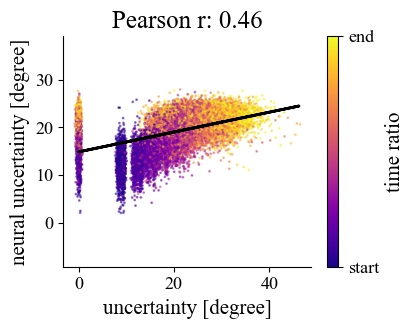

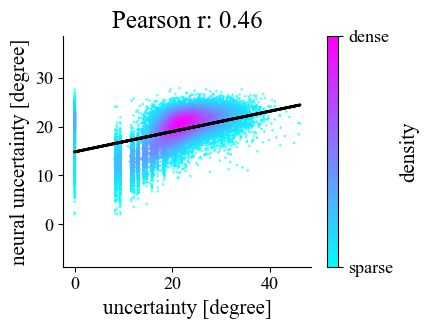

In [15]:
'''#neural to uncertainty (hori direction. **0.5 to same unit)'''

# thisx,thisy,thisc=np.stack(timedf.PPC.to_numpy()),np.stack(timedf['uncertainty'].to_numpy())[:,0,0]**0.5,timedf.timeratio.to_numpy()
# # thisy,thisc=zip(*process_list([thisy,thisc]))
# thisx,thisy,thisc=np.array(thisx),np.array(thisy),np.array(thisc)
# # thisc,_=process_one(thisc)
trialstart=2 # need to be >1 to take diffs.
thisx,thisy,thisc=np.concatenate([a[trialstart:] for a in sessdf.PPC.to_numpy()]), np.concatenate([a[trialstart:] for a in sessdf.relcov.to_numpy()])[:,0,0]**0.5, np.concatenate([a[trialstart:] for a in sessdf.time_ratio.to_numpy()]) 
thisxname, thisyname, thiscname='neural uncertainty [degree]', 'uncertainty [degree]','time ratio'

model = LinearRegression()
model.fit(thisx,thisy)
thispred=model.predict(thisx)

# fig, ax = plt.subplots(figsize=(3,3))
# c=ax.scatter(thispred,thisy+np.random.randn(*thisc.shape)*0.25, c=thisc, cmap='plasma', s=1, alpha=0.5)
# cbar=plt.colorbar(c, label=f'{thiscname}')
# cbar.set_ticks([min(thisc),max(thisc)],labels=['start','end'])
# solidcbar(cbar)
# slope=plot_best_fit(thispred,thisy, ax)
# r,_=pearsonr(thispred,thisy)
# ax.set_title(f'Pearson r: {r:.2f}')
# ax.set_xlabel(f'{thisxname}')
# ax.set_ylabel(f'{thisyname}')
# ax.axis('equal')
# plt.show()

# scatter_density=compute_scatter_density(thispred,thisy)
# fig, ax = plt.subplots(figsize=(3,3))
# c=ax.scatter(thispred,thisy, c=scatter_density, cmap='cool', s=1, alpha=0.5)
# cbar=plt.colorbar(c, label=f'density', ticks=[0,1])
# cbar.set_ticks([min(scatter_density),max(scatter_density)],labels=['sparse','dense'])
# solidcbar(cbar)
# slope=plot_best_fit(thispred,thisy, ax)
# r,_=pearsonr(thispred,thisy)
# ax.set_title(f'Pearson r: {r:.2f}')
# ax.set_xlabel(f'{thisxname}')
# ax.set_ylabel(f'{thisyname}')
# ax.axis('equal')
# plt.show()

fig, ax = plt.subplots(figsize=(4,3))
c=ax.scatter(thisy+np.random.randn(*thisc.shape)*0.25,thispred, c=thisc, cmap='plasma', s=1, alpha=0.5)
cbar=plt.colorbar(c, label=f'{thiscname}')
cbar.set_ticks([min(thisc),max(thisc)],labels=['start','end'])
solidcbar(cbar)
slope=plot_best_fit(thisy, thispred, ax)
r,_=pearsonr(thisy,thispred)
ax.set_title(f'Pearson r: {r:.2f}')
ax.set_ylabel(f'{thisxname}')
ax.set_xlabel(f'{thisyname}')
ax.axis('equal')
plt.show()

scatter_density=compute_scatter_density(thisy,thispred)
fig, ax = plt.subplots(figsize=(4,3))
c=ax.scatter(thisy,thispred, c=scatter_density, cmap='cool', s=1, alpha=0.5)
cbar=plt.colorbar(c, label=f'density', ticks=[0,1])
cbar.set_ticks([min(scatter_density),max(scatter_density)],labels=['sparse','dense'])
solidcbar(cbar) 
slope=plot_best_fit(thisy, thispred, ax)
r,_=pearsonr(thisy,thispred)
ax.set_title(f'Pearson r: {r:.2f}')
ax.set_ylabel(f'{thisxname}')
ax.set_xlabel(f'{thisyname}')
ax.axis('equal')
plt.show()

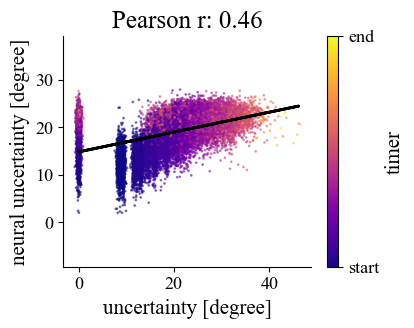

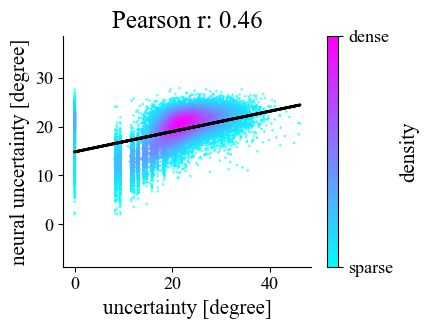

In [16]:
'''same plot, double check with trial timer, instead of time ratio'''

trialstart=2 # need to be >1 to take diffs.
thisx,thisy,thisc=np.concatenate([a[trialstart:] for a in sessdf.PPC.to_numpy()]), np.concatenate([a[trialstart:] for a in sessdf.relcov.to_numpy()])[:,0,0]**0.5, np.concatenate([a[trialstart:] for a in sessdf.timer.to_numpy()]) 
thisxname, thisyname, thiscname='neural uncertainty [degree]', 'uncertainty [degree]','timer'



model = LinearRegression()
model.fit(thisx,thisy)
thispred=model.predict(thisx)

fig, ax = plt.subplots(figsize=(4,3))
c=ax.scatter(thisy+np.random.randn(*thisc.shape)*0.25,thispred, c=thisc, cmap='plasma', s=1, alpha=0.5)
cbar=plt.colorbar(c, label=f'{thiscname}')
cbar.set_ticks([min(thisc),max(thisc)],labels=['start','end'])
cbar.solids.set_edgecolor("face")
cbar.solids.set_alpha(1) 
slope=plot_best_fit(thisy, thispred, ax)
r,_=pearsonr(thisy,thispred)
ax.set_title(f'Pearson r: {r:.2f}')
ax.set_ylabel(f'{thisxname}')
ax.set_xlabel(f'{thisyname}')
ax.axis('equal')
plt.show()

scatter_density=compute_scatter_density(thisy,thispred)
fig, ax = plt.subplots(figsize=(4,3))
c=ax.scatter(thisy,thispred, c=scatter_density, cmap='cool', s=1, alpha=0.5)
cbar=plt.colorbar(c, label=f'density', ticks=[0,1])
cbar.set_ticks([min(scatter_density),max(scatter_density)],labels=['sparse','dense'])
cbar.solids.set_edgecolor("face")
cbar.solids.set_alpha(1) 
slope=plot_best_fit(thisy, thispred, ax)
r,_=pearsonr(thisy,thispred)
ax.set_title(f'Pearson r: {r:.2f}')
ax.set_ylabel(f'{thisxname}')
ax.set_xlabel(f'{thisyname}')
ax.axis('equal')
plt.show()

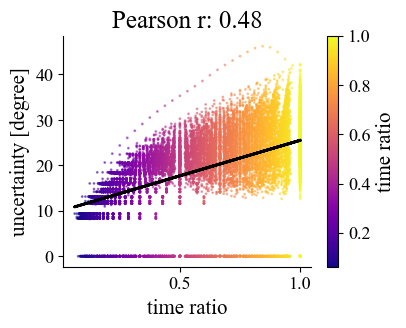

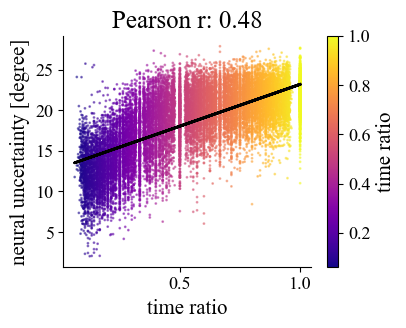

In [15]:
'''# uncertainty tightly correlate with time'''
# neural_data,beh_uncertainty,thisc=np.stack(timedf.PPC.to_numpy()),np.stack(timedf['uncertainty'].to_numpy())[:,0,0],timedf.timer.to_numpy()
# # beh_uncertainty,thisc=zip(*process_list([beh_uncertainty,thisc]))
# neural_data,beh_uncertainty,thisc=np.array(neural_data),np.array(beh_uncertainty),np.array(thisc)
# # thisc,_=process_one(thisc)'

trialstart=2 # need to be >1 to take diffs.
neural_data,beh_uncertainty,thisc=np.concatenate([a[trialstart:] for a in sessdf.PPC.to_numpy()]), np.concatenate([a[trialstart:] for a in sessdf.relcov.to_numpy()])[:,0,0]**0.5, np.concatenate([a[trialstart:] for a in sessdf.time_ratio.to_numpy()]) 
thiscname='time ratio'

model = LinearRegression()
model.fit(neural_data,beh_uncertainty)
neural_uncertainty=model.predict(neural_data)

fig, ax = plt.subplots(figsize=(4,3))
c=ax.scatter(thisc,beh_uncertainty+np.random.randn(*thisc.shape)*0., c=thisc, cmap='plasma', s=1, alpha=0.5)
cbar=plt.colorbar(c, label=f'{thiscname}')
solidcbar(cbar)
slope=plot_best_fit(thisc,beh_uncertainty, ax)
r,_=pearsonr(thisc,beh_uncertainty)
ax.set_title(f'Pearson r: {r:.2f}')
ax.set_xlabel(f'{thiscname}')
ax.set_ylabel('uncertainty [degree]')
# ax.axis('equal')
plt.show()

fig, ax = plt.subplots(figsize=(4,3))
c=ax.scatter(thisc+np.random.randn(*thisc.shape)*0.,neural_uncertainty, c=thisc, cmap='plasma', s=1, alpha=0.5)
cbar=plt.colorbar(c, label=f'{thiscname}')
solidcbar(cbar)
slope=plot_best_fit(thisc,neural_uncertainty, ax)
r,_=pearsonr(thisc,beh_uncertainty)
ax.set_title(f'Pearson r: {r:.2f}')
ax.set_xlabel(f'{thiscname}')
ax.set_ylabel('neural uncertainty [degree]')
# ax.axis('equal')
plt.show()

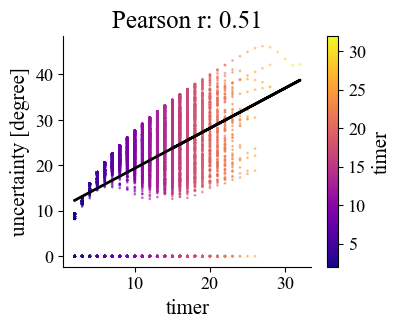

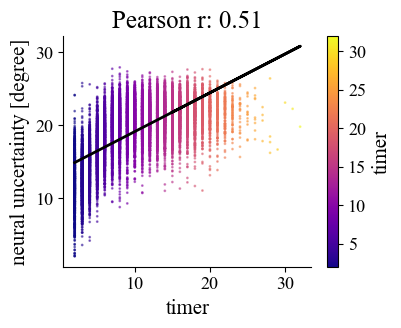

In [17]:
'''# uncertainty tightly correlate with time'''
# neural_data,beh_uncertainty,thisc=np.stack(timedf.PPC.to_numpy()),np.stack(timedf['uncertainty'].to_numpy())[:,0,0],timedf.timer.to_numpy()
# # beh_uncertainty,thisc=zip(*process_list([beh_uncertainty,thisc]))
# neural_data,beh_uncertainty,thisc=np.array(neural_data),np.array(beh_uncertainty),np.array(thisc)
# # thisc,_=process_one(thisc)'

trialstart=2 # need to be >1 to take diffs.
neural_data,beh_uncertainty,thisc=np.concatenate([a[trialstart:] for a in sessdf.PPC.to_numpy()]), np.concatenate([a[trialstart:] for a in sessdf.relcov.to_numpy()])[:,0,0]**0.5, np.concatenate([a[trialstart:] for a in sessdf.timer.to_numpy()]) 
thiscname='timer'

model = LinearRegression()
model.fit(neural_data,beh_uncertainty)
neural_uncertainty=model.predict(neural_data)

fig, ax = plt.subplots(figsize=(4,3))
c=ax.scatter(thisc,beh_uncertainty+np.random.randn(*thisc.shape)*0., c=thisc, cmap='plasma', s=1, alpha=0.5)
cbar=plt.colorbar(c, label=f'{thiscname}')
solidcbar(cbar)
slope=plot_best_fit(thisc,beh_uncertainty, ax)
r,_=pearsonr(thisc,beh_uncertainty)
ax.set_title(f'Pearson r: {r:.2f}')
ax.set_xlabel(f'{thiscname}')
ax.set_ylabel('uncertainty [degree]')
# ax.axis('equal')
plt.show()

fig, ax = plt.subplots(figsize=(4,3))
c=ax.scatter(thisc+np.random.randn(*thisc.shape)*0.,neural_uncertainty, c=thisc, cmap='plasma', s=1, alpha=0.5)
cbar=plt.colorbar(c, label=f'{thiscname}')
solidcbar(cbar)
slope=plot_best_fit(thisc,neural_uncertainty, ax)
r,_=pearsonr(thisc,beh_uncertainty)
ax.set_title(f'Pearson r: {r:.2f}')
ax.set_xlabel(f'{thiscname}')
ax.set_ylabel('neural uncertainty [degree]')
# ax.axis('equal')
plt.show()

take home msg from above: we can fit neural activity to behavioral belief uncertainty. but it also tightly related to time. need to make sure we found actual uncertainty in neural activity instead of time.

## select large diff (uncertainty, time)

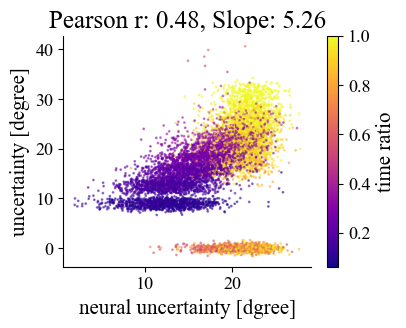

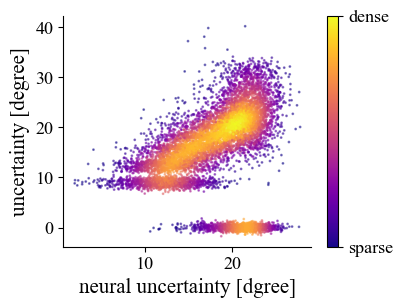

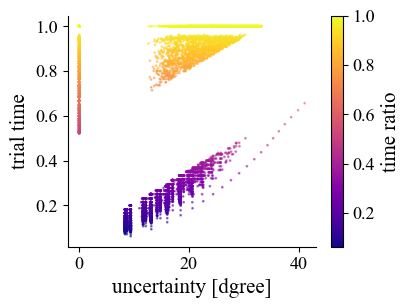

In [17]:
'''select uncertainty-time differs (large error)
and check do they have some other task variable dim pattern. have not found yet.

train on all data, test on decouple data
'''

trialstart=2 # need to be >1 to take diffs.
neural_data,beh_uncertainty,trial_time=np.concatenate([a[trialstart:] for a in sessdf.PPC.to_numpy()]), np.concatenate([a[trialstart:] for a in sessdf.relcov.to_numpy()])[:,0,0]**0.5, np.concatenate([a[trialstart:] for a in sessdf.time_ratio.to_numpy()]) 
trial_timename='time ratio'

# get mask (decouple time and uncertainty)
model = LinearRegression()
model.fit(beh_uncertainty.reshape(-1, 1),trial_time)
pred_time=model.predict(beh_uncertainty.reshape(-1, 1))
err=np.array(normalize_z(np.abs(pred_time-trial_time)))
mask=err>0.2

# get neural uncertainty
model = LinearRegression()
model.fit(neural_data,beh_uncertainty)
neural_uncertainty=model.predict(neural_data)
neural_uncertainty,beh_uncertainty, trial_time = neural_uncertainty[mask],beh_uncertainty[mask], trial_time[mask]


fig, ax = plt.subplots(figsize=(4,3))
c=ax.scatter(neural_uncertainty, beh_uncertainty+np.random.randn(*beh_uncertainty.shape)*0.5, c=trial_time, cmap='plasma', s=1, alpha=0.5)
cbar=plt.colorbar(c, label=f'{trial_timename}')
solidcbar(cbar)
# slope=plot_best_fit(neural_uncertainty, beh_uncertainty+np.random.randn(*beh_uncertainty.shape)*0.5, ax)
# r,_=pearsonr(neural_uncertainty,beh_uncertainty)
ax.set_title(f'Pearson r: {r:.2f}, Slope: {slope:.2f}')
ax.set_xlabel(f'neural uncertainty [dgree]')
ax.set_ylabel(f'uncertainty [degree]')
plt.show()

fig, ax = plt.subplots(figsize=(4,3))
scatter_density=compute_scatter_density(neural_uncertainty, beh_uncertainty)
c=ax.scatter(neural_uncertainty, beh_uncertainty+np.random.randn(*beh_uncertainty.shape)*0.5, c=scatter_density, cmap='plasma', s=1, alpha=0.5)
cbar=plt.colorbar(c)
cbar.set_ticks([min(scatter_density),max(scatter_density)],labels=['sparse','dense'])
solidcbar(cbar)
# slope=plot_best_fit(neural_uncertainty, beh_uncertainty, ax)
# r,_=pearsonr(neural_uncertainty,beh_uncertainty)
# ax.set_title(f'Pearson r: {r:.2f}, Slope: {slope:.2f}')
ax.set_xlabel(f'neural uncertainty [dgree]')
ax.set_ylabel(f'uncertainty [degree]')
plt.show()

fig, ax = plt.subplots(figsize=(4,3))
c=ax.scatter(beh_uncertainty, trial_time, c=trial_time, cmap='plasma', s=1, alpha=0.5)
cbar=plt.colorbar(c, label=f'{trial_timename}')
solidcbar(cbar)
ax.set_xlabel(f'uncertainty [dgree]')
ax.set_ylabel(f'trial time')
plt.show()

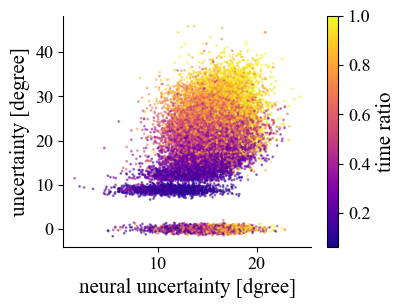

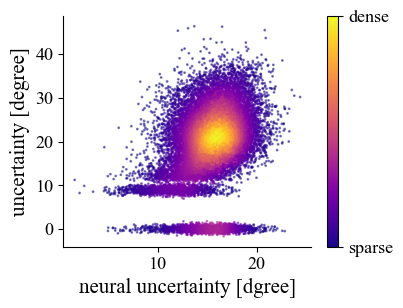

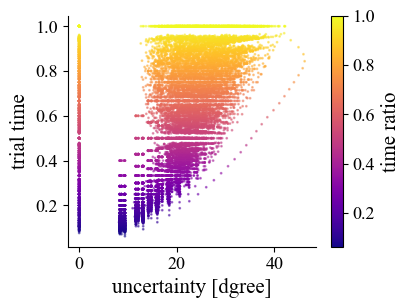

In [18]:

'''same as above, but use decouple time to find neural encoding, then test on all data.
'''

trialstart=2 # need to be >1 to take diffs.
neural_data,beh_uncertainty,trial_time=np.concatenate([a[trialstart:] for a in sessdf.PPC.to_numpy()]), np.concatenate([a[trialstart:] for a in sessdf.relcov.to_numpy()])[:,0,0]**0.5, np.concatenate([a[trialstart:] for a in sessdf.time_ratio.to_numpy()]) 
trial_timename='time ratio'

# get mask (decouple time and uncertainty)
model = LinearRegression()
model.fit(beh_uncertainty.reshape(-1, 1),trial_time)
pred_time=model.predict(beh_uncertainty.reshape(-1, 1))
err=np.array(normalize_z(np.abs(pred_time-trial_time)))
mask=err>0.2
# only use the decouple data to fit
neural_data,beh_uncertainty, trial_time = neural_data[mask],beh_uncertainty[mask], trial_time[mask]

# get neural uncertainty
model = LinearRegression()
model.fit(neural_data,beh_uncertainty)

# neural_uncertainty,beh_uncertainty, trial_time = neural_uncertainty[mask],beh_uncertainty[mask], trial_time[mask]
neural_data,beh_uncertainty,trial_time=np.concatenate([a[trialstart:] for a in sessdf.PPC.to_numpy()]), np.concatenate([a[trialstart:] for a in sessdf.relcov.to_numpy()])[:,0,0]**0.5, np.concatenate([a[trialstart:] for a in sessdf.time_ratio.to_numpy()]) 
neural_uncertainty=model.predict(neural_data)


fig, ax = plt.subplots(figsize=(4,3))
c=ax.scatter(neural_uncertainty, beh_uncertainty+np.random.randn(*beh_uncertainty.shape)*0.5, c=trial_time, cmap='plasma', s=1, alpha=0.5)
cbar=plt.colorbar(c, label=f'{trial_timename}')
solidcbar(cbar)
# slope=plot_best_fit(neural_uncertainty, beh_uncertainty+np.random.randn(*beh_uncertainty.shape)*0.5, ax)
# r,_=pearsonr(neural_uncertainty,beh_uncertainty)
# ax.set_title(f'Pearson r: {r:.2f}, Slope: {slope:.2f}')
ax.set_xlabel(f'neural uncertainty [dgree]')
ax.set_ylabel(f'uncertainty [degree]')
plt.show()

fig, ax = plt.subplots(figsize=(4,3))
scatter_density=compute_scatter_density(neural_uncertainty, beh_uncertainty)
c=ax.scatter(neural_uncertainty, beh_uncertainty+np.random.randn(*beh_uncertainty.shape)*0.5, c=scatter_density, cmap='plasma', s=1, alpha=0.5)
cbar=plt.colorbar(c)
cbar.set_ticks([min(scatter_density),max(scatter_density)],labels=['sparse','dense'])
solidcbar(cbar)
# slope=plot_best_fit(neural_uncertainty, beh_uncertainty, ax)
# r,_=pearsonr(neural_uncertainty,beh_uncertainty)
# ax.set_title(f'Pearson r: {r:.2f}, Slope: {slope:.2f}')
ax.set_xlabel(f'neural uncertainty [dgree]')
ax.set_ylabel(f'uncertainty [degree]')
plt.show()

fig, ax = plt.subplots(figsize=(4,3))
c=ax.scatter(beh_uncertainty, trial_time, c=trial_time, cmap='plasma', s=1, alpha=0.5)
cbar=plt.colorbar(c, label=f'{trial_timename}')
solidcbar(cbar)
ax.set_xlabel(f'uncertainty [dgree]')
ax.set_ylabel(f'trial time')
plt.show()

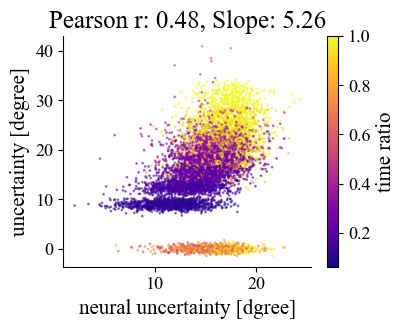

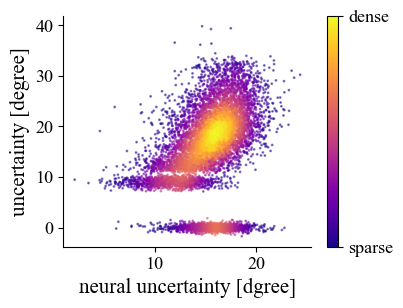

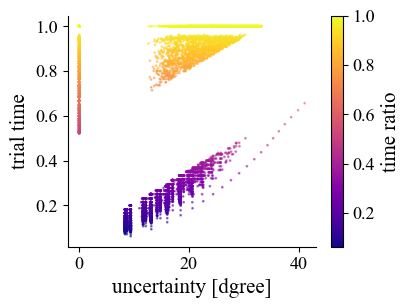

In [19]:

'''same as above, but use decouple time to find neural encoding, then test on same decouple data.
'''

trialstart=2 # need to be >1 to take diffs.
neural_data,beh_uncertainty,trial_time=np.concatenate([a[trialstart:] for a in sessdf.PPC.to_numpy()]), np.concatenate([a[trialstart:] for a in sessdf.relcov.to_numpy()])[:,0,0]**0.5, np.concatenate([a[trialstart:] for a in sessdf.time_ratio.to_numpy()]) 
trial_timename='time ratio'

# get mask (decouple time and uncertainty)
model = LinearRegression()
model.fit(beh_uncertainty.reshape(-1, 1),trial_time)
pred_time=model.predict(beh_uncertainty.reshape(-1, 1))
err=np.array(normalize_z(np.abs(pred_time-trial_time)))
mask=err>0.2
# only use the decouple data to fit
neural_data,beh_uncertainty, trial_time = neural_data[mask],beh_uncertainty[mask], trial_time[mask]

# get neural uncertainty
model = LinearRegression()
model.fit(neural_data,beh_uncertainty)
neural_uncertainty=model.predict(neural_data)


fig, ax = plt.subplots(figsize=(4,3))
c=ax.scatter(neural_uncertainty, beh_uncertainty+np.random.randn(*beh_uncertainty.shape)*0.5, c=trial_time, cmap='plasma', s=1, alpha=0.5)
cbar=plt.colorbar(c, label=f'{trial_timename}')
solidcbar(cbar)
# slope=plot_best_fit(neural_uncertainty, beh_uncertainty+np.random.randn(*beh_uncertainty.shape)*0.5, ax)
# r,_=pearsonr(neural_uncertainty,beh_uncertainty)
ax.set_title(f'Pearson r: {r:.2f}, Slope: {slope:.2f}')
ax.set_xlabel(f'neural uncertainty [dgree]')
ax.set_ylabel(f'uncertainty [degree]')
plt.show()

fig, ax = plt.subplots(figsize=(4,3))
scatter_density=compute_scatter_density(neural_uncertainty, beh_uncertainty)
c=ax.scatter(neural_uncertainty, beh_uncertainty+np.random.randn(*beh_uncertainty.shape)*0.5, c=scatter_density, cmap='plasma', s=1, alpha=0.5)
cbar=plt.colorbar(c)
cbar.set_ticks([min(scatter_density),max(scatter_density)],labels=['sparse','dense'])
solidcbar(cbar)
# slope=plot_best_fit(neural_uncertainty, beh_uncertainty, ax)
# r,_=pearsonr(neural_uncertainty,beh_uncertainty)
# ax.set_title(f'Pearson r: {r:.2f}, Slope: {slope:.2f}')
ax.set_xlabel(f'neural uncertainty [dgree]')
ax.set_ylabel(f'uncertainty [degree]')
plt.show()

fig, ax = plt.subplots(figsize=(4,3))
c=ax.scatter(beh_uncertainty, trial_time, c=trial_time, cmap='plasma', s=1, alpha=0.5)
cbar=plt.colorbar(c, label=f'{trial_timename}')
solidcbar(cbar)
ax.set_xlabel(f'uncertainty [dgree]')
ax.set_ylabel(f'trial time')
plt.show()

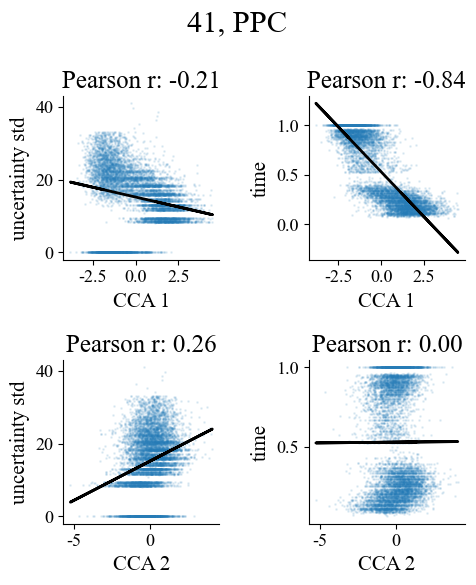

In [20]:

'''
CCA decouple data
'''

trialstart=2 # need to be >1 to take diffs.
neural_data,beh_uncertainty,trial_time=np.concatenate([a[trialstart:] for a in sessdf.PPC.to_numpy()]), np.concatenate([a[trialstart:] for a in sessdf.relcov.to_numpy()])[:,0,0]**0.5, np.concatenate([a[trialstart:] for a in sessdf.time_ratio.to_numpy()]) 
trial_timename='time ratio'

# get mask (decouple time and uncertainty)
model = LinearRegression()
model.fit(beh_uncertainty.reshape(-1, 1),trial_time)
pred_time=model.predict(beh_uncertainty.reshape(-1, 1))
err=np.array(normalize_z(np.abs(pred_time-trial_time)))
mask=err>0.2
# only use the decouple data to fit
neural_data,beh_uncertainty, trial_time = neural_data[mask],beh_uncertainty[mask], trial_time[mask]

# get neural uncertainty
model = LinearRegression()
model.fit(neural_data,beh_uncertainty)
neural_uncertainty=model.predict(neural_data)

related_taskvar=np.stack([beh_uncertainty, trial_time]).T
cca = CCA(n_components=2)
cca_neural, cca_be=cca.fit_transform(neural_data,related_taskvar)


varname=['uncertainty std', 'time']
fig, axs = plt.subplots(2,2, figsize=(5,6))
for i in range(2):
    for j in range(2):
        ax=axs[i,j]
        ax.scatter(cca_neural[:,i],related_taskvar[:,j], s=1, alpha=0.1)
        # best fit line
        slope, intercept = np.polyfit(cca_neural[:,i],related_taskvar[:,j], 1)
        best_fit_line = slope * cca_neural[:,i] + intercept
        ax.plot(cca_neural[:,i], best_fit_line, color='black')
        # quickallspine(ax)
        # ax.axis('equal')
        r,_=pearsonr(cca_neural[:,i],related_taskvar[:,j])
        # ax.set_title(f'x: cca {i+1} \ny: {varname[j]}\nPeason r: {r:.2f}')
        ax.set_title(f'Pearson r: {r:.2f}')
        ax.set_xlabel(f'CCA {i+1}')
        ax.set_ylabel(f'{varname[j]}')
plt.suptitle(f'{session}, PPC', fontsize=22)
plt.tight_layout()
plt.show()


summary above: by selecting the decouple data, where uncerainty differs from time, we still see neural correlate with uncertainty. this is good. but more tests are needed

0.0001 659.4021989440323
0.0005 812.4132306961747
0.001 738.7215833699496
0.005 649.9286801196208


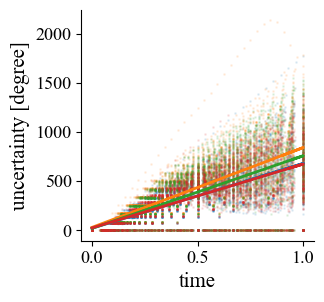

In [21]:
'''# select different density
different density should show different uncerainty incresase speed. but minor here. 
could make sense because the animal have very similar performance in different density.
'''
# from matplotlib.colors import ListedColormap
tab10=plt.get_cmap('tab10').colors

fig, ax = plt.subplots(figsize=(3,3))
for thisidx, density in enumerate(sorted(timedf.density.unique())):
    thistimedf=timedf[timedf.density==density]
    thisx,thisy,thisc=np.stack(thistimedf.timeratio.to_numpy()),np.stack(thistimedf.uncertainty.to_numpy())[:,0,0],thistimedf.timer.to_numpy()
    # thisy,thisc=zip(*process_list([thisy,thisc]))
    thisx,thisy,thisc=np.array(thisx),np.array(thisy),np.array(thisc)
    # thisc,_=process_one(thisc)
    thisxname, thisyname, thiscname='time', 'uncertainty [degree]','time ratio'

    # from sklearn.linear_model import LinearRegression
    # model = LinearRegression()
    # model.fit(thisx,thisy)
    # thispred=model.predict(thisx)

    c=ax.scatter(thisx,thisy, s=1, alpha=0.1, label=f'{density}')
    # plt.colorbar(c, label=f'{thiscname}')

    slope=plot_best_fit(thisx,thisy, ax, color=tab10[thisidx])
    print(density, slope)
    r,_=pearsonr(thisx,thisy)
    # ax.set_title(f'Pearson r: {r:.2f}')

    ax.set_xlabel(f'{thisxname}')
    ax.set_ylabel(f'{thisyname}')
    # ax.axis('equal')
# plt.legend()
plt.show()


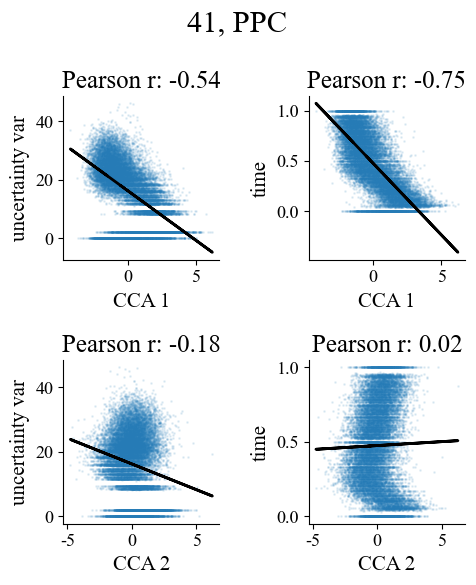

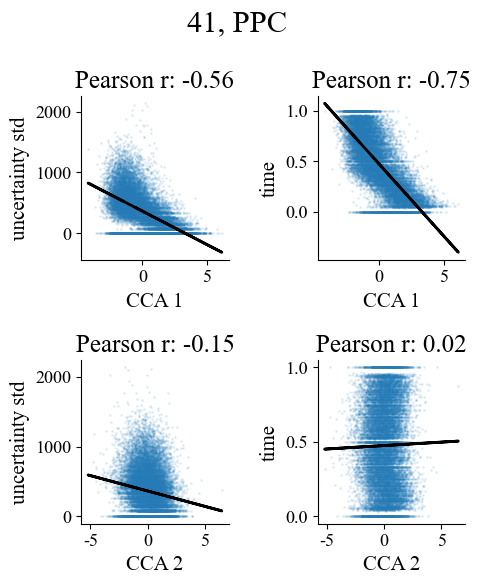

In [22]:
'''use cca to show neural encode both time and uncertainty
use cca to seperate time and unceratinty. not good
'''
thisx,thisy,thisc=np.stack(timedf.PPC.to_numpy()),np.stack(timedf.uncertainty.to_numpy())[:,0,0]**0.5,timedf.timeratio.to_numpy()
# thisy,thisc=zip(*process_list([thisy,thisc]))
thisx,thisy,thisc=np.array(thisx),np.array(thisy),np.array(thisc)
# thisc,_=process_one(thisc)
thisxname, thisyname, thiscname='neural pred uncertainty', 'uncertainty','time ratio'

related_taskvar=np.stack([thisy, thisc]).T
cca = CCA(n_components=2)
cca_neural, cca_be=cca.fit_transform(thisx,related_taskvar )


varname=['uncertainty var', 'time']
fig, axs = plt.subplots(2,2, figsize=(5,6))
for i in range(2):
    for j in range(2):
        ax=axs[i,j]
        ax.scatter(cca_neural[:,i],related_taskvar[:,j], s=1, alpha=0.1)
        # best fit line
        slope, intercept = np.polyfit(cca_neural[:,i],related_taskvar[:,j], 1)
        best_fit_line = slope * cca_neural[:,i] + intercept
        ax.plot(cca_neural[:,i], best_fit_line, color='black')
        # quickallspine(ax)
        # ax.axis('equal')
        r,_=pearsonr(cca_neural[:,i],related_taskvar[:,j])
        # ax.set_title(f'x: cca {i+1} \ny: {varname[j]}\nPeason r: {r:.2f}')
        ax.set_title(f'Pearson r: {r:.2f}')
        ax.set_xlabel(f'CCA {i+1}')
        ax.set_ylabel(f'{varname[j]}')
plt.suptitle(f'{session}, PPC', fontsize=22)
plt.tight_layout()
plt.show()


'''# follow up, neural could encode just time. use cca to show neural encode both time and uncertainty
use cca to seperate time and unceratinty. not good
'''
thisx,thisy,thisc=np.stack(timedf.PPC.to_numpy()),np.stack(timedf.uncertainty.to_numpy())[:,0,0],timedf.timeratio.to_numpy()
# thisy,thisc=zip(*process_list([thisy,thisc]))
thisx,thisy,thisc=np.array(thisx),np.array(thisy),np.array(thisc)
# thisc,_=process_one(thisc)
thisxname, thisyname, thiscname='neural pred uncertainty', 'uncertainty','time ratio'

related_taskvar=np.stack([thisy, thisc]).T
cca = CCA(n_components=2)
cca_neural, cca_be=cca.fit_transform(thisx,related_taskvar )


varname=['uncertainty std', 'time']
fig, axs = plt.subplots(2,2, figsize=(5,6))
for i in range(2):
    for j in range(2):
        ax=axs[i,j]
        ax.scatter(cca_neural[:,i],related_taskvar[:,j], s=1, alpha=0.1)
        # best fit line
        slope, intercept = np.polyfit(cca_neural[:,i],related_taskvar[:,j], 1)
        best_fit_line = slope * cca_neural[:,i] + intercept
        ax.plot(cca_neural[:,i], best_fit_line, color='black')
        # quickallspine(ax)
        # ax.axis('equal')
        r,_=pearsonr(cca_neural[:,i],related_taskvar[:,j])
        # ax.set_title(f'x: cca {i+1} \ny: {varname[j]}\nPeason r: {r:.2f}')
        ax.set_title(f'Pearson r: {r:.2f}')
        ax.set_xlabel(f'CCA {i+1}')
        ax.set_ylabel(f'{varname[j]}')
plt.suptitle(f'{session}, PPC', fontsize=22)
plt.tight_layout()
plt.show()

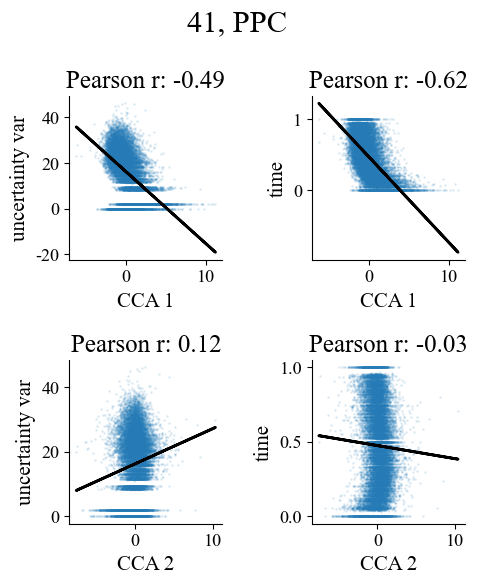

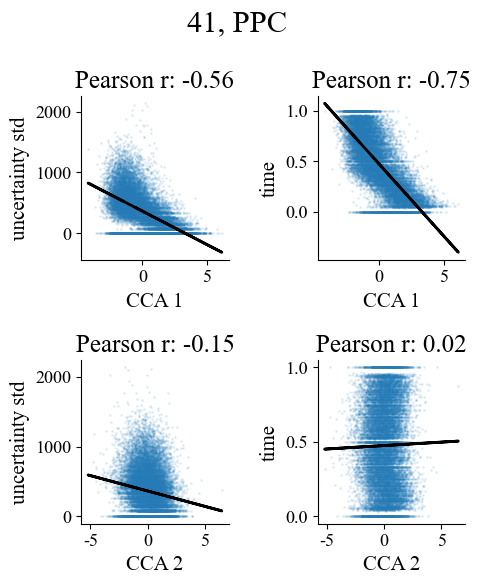

In [23]:
'''
use neural variance. use cca to show neural encode both time and uncertainty
use cca to seperate time and unceratinty. not good

'''
thisx,thisy,thisc=np.stack(timedf.PPC_var.to_numpy()),np.stack(timedf.uncertainty.to_numpy())[:,0,0]**0.5,timedf.timeratio.to_numpy()
# thisy,thisc=zip(*process_list([thisy,thisc]))
thisx,thisy,thisc=np.array(thisx),np.array(thisy),np.array(thisc)
# thisc,_=process_one(thisc)
thisxname, thisyname, thiscname='neural pred uncertainty', 'uncertainty','time ratio'

related_taskvar=np.stack([thisy, thisc]).T
cca = CCA(n_components=2)
cca_neural, cca_be=cca.fit_transform(thisx,related_taskvar )


varname=['uncertainty var', 'time']
fig, axs = plt.subplots(2,2, figsize=(5,6))
for i in range(2):
    for j in range(2):
        ax=axs[i,j]
        ax.scatter(cca_neural[:,i],related_taskvar[:,j], s=1, alpha=0.1)
        # best fit line
        slope, intercept = np.polyfit(cca_neural[:,i],related_taskvar[:,j], 1)
        best_fit_line = slope * cca_neural[:,i] + intercept
        ax.plot(cca_neural[:,i], best_fit_line, color='black')
        # quickallspine(ax)
        # ax.axis('equal')
        r,_=pearsonr(cca_neural[:,i],related_taskvar[:,j])
        # ax.set_title(f'x: cca {i+1} \ny: {varname[j]}\nPeason r: {r:.2f}')
        ax.set_title(f'Pearson r: {r:.2f}')
        ax.set_xlabel(f'CCA {i+1}')
        ax.set_ylabel(f'{varname[j]}')
plt.suptitle(f'{session}, PPC', fontsize=22)
plt.tight_layout()
plt.show()


'''# follow up, neural could encode just time. use cca to show neural encode both time and uncertainty
use cca to seperate time and unceratinty. not good
'''
thisx,thisy,thisc=np.stack(timedf.PPC.to_numpy()),np.stack(timedf.uncertainty.to_numpy())[:,0,0],timedf.timeratio.to_numpy()
# thisy,thisc=zip(*process_list([thisy,thisc]))
thisx,thisy,thisc=np.array(thisx),np.array(thisy),np.array(thisc)
# thisc,_=process_one(thisc)
thisxname, thisyname, thiscname='neural pred uncertainty', 'uncertainty','time ratio'

related_taskvar=np.stack([thisy, thisc]).T
cca = CCA(n_components=2)
cca_neural, cca_be=cca.fit_transform(thisx,related_taskvar )


varname=['uncertainty std', 'time']
fig, axs = plt.subplots(2,2, figsize=(5,6))
for i in range(2):
    for j in range(2):
        ax=axs[i,j]
        ax.scatter(cca_neural[:,i],related_taskvar[:,j], s=1, alpha=0.1)
        # best fit line
        slope, intercept = np.polyfit(cca_neural[:,i],related_taskvar[:,j], 1)
        best_fit_line = slope * cca_neural[:,i] + intercept
        ax.plot(cca_neural[:,i], best_fit_line, color='black')
        # quickallspine(ax)
        # ax.axis('equal')
        r,_=pearsonr(cca_neural[:,i],related_taskvar[:,j])
        # ax.set_title(f'x: cca {i+1} \ny: {varname[j]}\nPeason r: {r:.2f}')
        ax.set_title(f'Pearson r: {r:.2f}')
        ax.set_xlabel(f'CCA {i+1}')
        ax.set_ylabel(f'{varname[j]}')
plt.suptitle(f'{session}, PPC', fontsize=22)
plt.tight_layout()
plt.show()

In [24]:
cca.y_loadings_

array([[-0.69490666, -0.99424744],
       [-0.93092544,  0.10710757]])

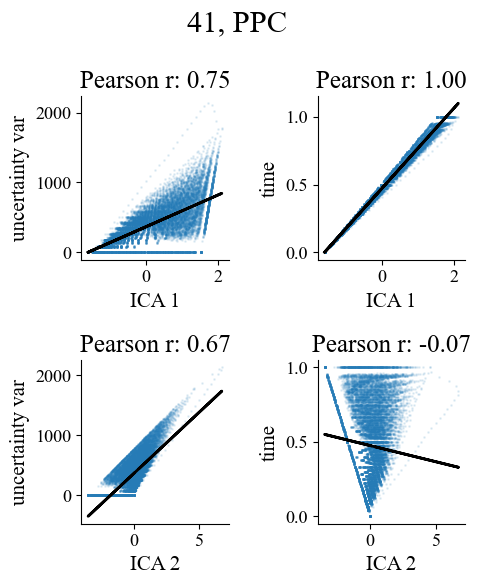

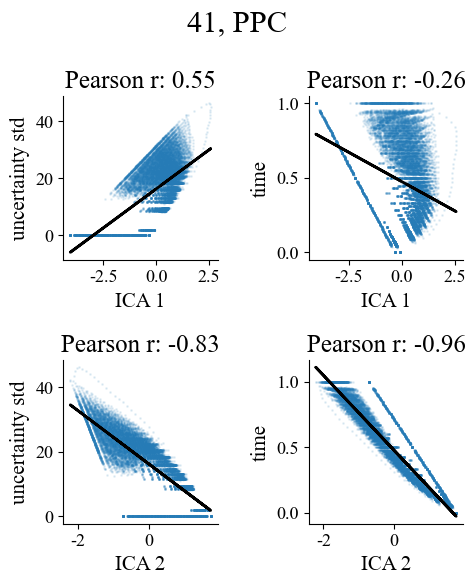

In [25]:
'''# use ica to seperate the time and uncerainty
'''
thisx,thisy,thisc=np.stack(timedf.PPC.to_numpy()),np.stack(timedf.uncertainty.to_numpy())[:,0,0],timedf.timeratio.to_numpy()
# thisy,thisc=zip(*process_list([thisy,thisc]))
thisx,thisy,thisc=np.array(thisx),np.array(thisy),np.array(thisc)
# thisc,_=process_one(thisc)
thisxname, thisyname, thiscname='neural pred uncertainty', 'uncertainty','time ratio'

related_taskvar=np.stack([thisy, thisc]).T
ica = FastICA(n_components=2)
icaX=related_taskvar
icaS = ica.fit_transform(icaX) 


varname=['uncertainty var', 'time']
fig, axs = plt.subplots(2,2, figsize=(5,6))
for i in range(2):
    for j in range(2):
        ax=axs[i,j]
        ax.scatter(icaS[:,i],related_taskvar[:,j], s=1, alpha=0.1)
        # best fit line
        slope, intercept = np.polyfit(icaS[:,i],related_taskvar[:,j], 1)
        best_fit_line = slope * icaS[:,i] + intercept
        ax.plot(icaS[:,i], best_fit_line, color='black')
        # quickallspine(ax)
        # ax.axis('equal')
        r,_=pearsonr(icaS[:,i],related_taskvar[:,j])
        # ax.set_title(f'x: cca {i+1} \ny: {varname[j]}\nPeason r: {r:.2f}')
        ax.set_title(f'Pearson r: {r:.2f}')
        ax.set_xlabel(f'ICA {i+1}')
        ax.set_ylabel(f'{varname[j]}')
plt.suptitle(f'{session}, PPC', fontsize=22)
plt.tight_layout()
plt.show()



thisx,thisy,thisc=np.stack(timedf.PPC.to_numpy()),np.stack(timedf.uncertainty.to_numpy())[:,0,0]**0.5,timedf.timeratio.to_numpy()
# thisy,thisc=zip(*process_list([thisy,thisc]))
thisx,thisy,thisc=np.array(thisx),np.array(thisy),np.array(thisc)
# thisc,_=process_one(thisc)
thisxname, thisyname, thiscname='neural pred uncertainty', 'uncertainty','time ratio'

related_taskvar=np.stack([thisy, thisc]).T
ica = FastICA(n_components=2)
icaX=related_taskvar
icaS = ica.fit_transform(icaX) 


varname=['uncertainty std', 'time']
fig, axs = plt.subplots(2,2, figsize=(5,6))
for i in range(2):
    for j in range(2):
        ax=axs[i,j]
        ax.scatter(icaS[:,i],related_taskvar[:,j], s=1, alpha=0.1)
        # best fit line
        slope, intercept = np.polyfit(icaS[:,i],related_taskvar[:,j], 1)
        best_fit_line = slope * icaS[:,i] + intercept
        ax.plot(icaS[:,i], best_fit_line, color='black')
        # quickallspine(ax)
        # ax.axis('equal')
        r,_=pearsonr(icaS[:,i],related_taskvar[:,j])
        # ax.set_title(f'x: cca {i+1} \ny: {varname[j]}\nPeason r: {r:.2f}')
        ax.set_title(f'Pearson r: {r:.2f}')
        ax.set_xlabel(f'ICA {i+1}')
        ax.set_ylabel(f'{varname[j]}')
plt.suptitle(f'{session}, PPC', fontsize=22)
plt.tight_layout()
plt.show()


# work

idea:

here in this notebook, we study neural encoding of uncertainty.
we have ppc, ddc, mainly.
let focus only on the encoding for now, ignoring their inference and update.
things are simple.

in ppc, neural encode parametric representation of the distribution, meaning the mean and covariance. we confirmed the mean already. so, we just need to fit the neural activity against the covariance.

in ddc, neural encode a sample from the distribution. that is, variance of neural activity reflect the variance of belief uncertainty. we need to somehow meansure this neural variance, and fit it against the covariance. 

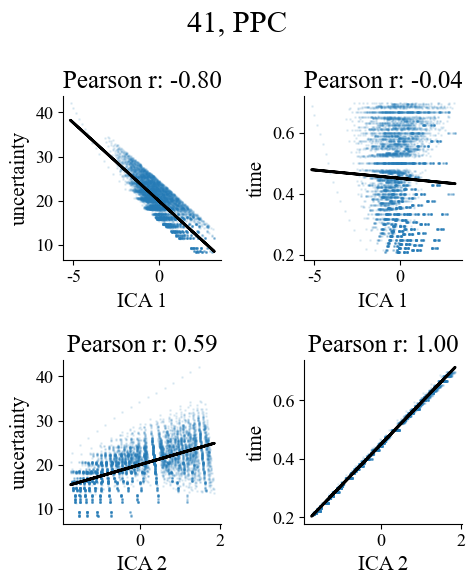

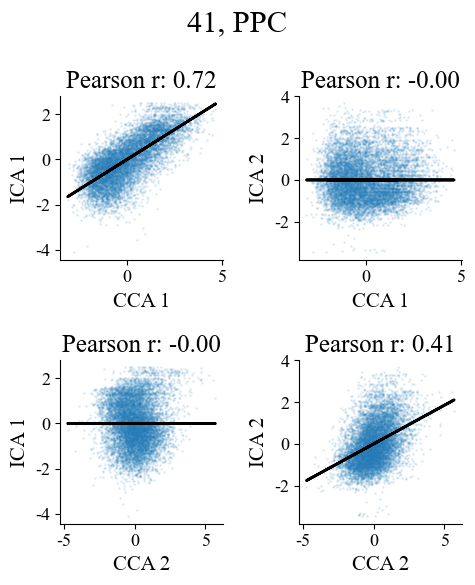

In [26]:
'''only use the tracking part out of 3 segment in a trial. check unceratinty fitting seperately.
conclusion: something. but this method is hard to explain.
'''

# pre tracking 
# thisdf=timedf[(timedf.fullon==0)&((timedf.timeratio<0.2))]

# tracking 
thisdf=timedf[(timedf.fullon==0)&((timedf.timeratio<0.7)&(timedf.timeratio>0.2))]

# post tracking 
# thisdf=timedf[(timedf.fullon==0)&((timedf.timeratio>0.7))]

thisx,thisy,thisc=np.stack(thisdf.PPC.to_numpy()),np.stack(thisdf.uncertainty.to_numpy())[:,0,0]**0.5,thisdf.timeratio.to_numpy()
# thisy,thisc=zip(*process_list([thisy,thisc]))
thisx,thisy,thisc=np.array(thisx),np.array(thisy),np.array(thisc)
# thisc,_=process_one(thisc)
thisxname, thisyname, thiscname='neural pred uncertainty', 'uncertainty','time ratio'

related_taskvar=np.stack([thisy, thisc]).T
ica = FastICA(n_components=2)
icaX=related_taskvar
icaS = ica.fit_transform(icaX) 


varname=['uncertainty', 'time']
fig, axs = plt.subplots(2,2, figsize=(5,6))
for i in range(2):
    for j in range(2):
        ax=axs[i,j]
        ax.scatter(icaS[:,i],related_taskvar[:,j], s=1, alpha=0.1)
        # best fit line
        slope, intercept = np.polyfit(icaS[:,i],related_taskvar[:,j], 1)
        best_fit_line = slope * icaS[:,i] + intercept
        ax.plot(icaS[:,i], best_fit_line, color='black')
        # quickallspine(ax)
        # ax.axis('equal')
        r,_=pearsonr(icaS[:,i],related_taskvar[:,j])
        # ax.set_title(f'x: cca {i+1} \ny: {varname[j]}\nPeason r: {r:.2f}')
        ax.set_title(f'Pearson r: {r:.2f}')
        ax.set_xlabel(f'ICA {i+1}')
        ax.set_ylabel(f'{varname[j]}')
plt.suptitle(f'{session}, PPC', fontsize=22)
plt.tight_layout()
plt.show()


thisx,thisy,thisc=np.stack(thisdf.PPC.to_numpy()),np.stack(thisdf.uncertainty.to_numpy())[:,0,0]**0.5,thisdf.timeratio.to_numpy()
# thisy,thisc=zip(*process_list([thisy,thisc]))
thisx,thisy,thisc=np.array(thisx),np.array(thisy),np.array(thisc)
# thisc,_=process_one(thisc)
thisxname, thisyname, thiscname='neural pred uncertainty', 'uncertainty','time ratio'

related_taskvar=np.stack([thisy, thisc]).T
cca = CCA(n_components=2)
cca_neural, cca_be=cca.fit_transform(thisx,icaS )


varname=['ICA 1', 'ICA 2']
fig, axs = plt.subplots(2,2, figsize=(5,6))
for i in range(2):
    for j in range(2):
        ax=axs[i,j]
        ax.scatter(cca_neural[:,i],cca_be[:,j], s=1, alpha=0.1)
        # best fit line
        slope, intercept = np.polyfit(cca_neural[:,i],cca_be[:,j], 1)
        best_fit_line = slope * cca_neural[:,i] + intercept
        ax.plot(cca_neural[:,i], best_fit_line, color='black')
        # quickallspine(ax)
        # ax.axis('equal')
        r,_=pearsonr(cca_neural[:,i],cca_be[:,j])
        # ax.set_title(f'x: cca {i+1} \ny: {varname[j]}\nPeason r: {r:.2f}')
        ax.set_title(f'Pearson r: {r:.2f}')
        ax.set_xlabel(f'CCA {i+1}')
        ax.set_ylabel(f'{varname[j]}')
plt.suptitle(f'{session}, PPC', fontsize=22)
plt.tight_layout()
plt.show()


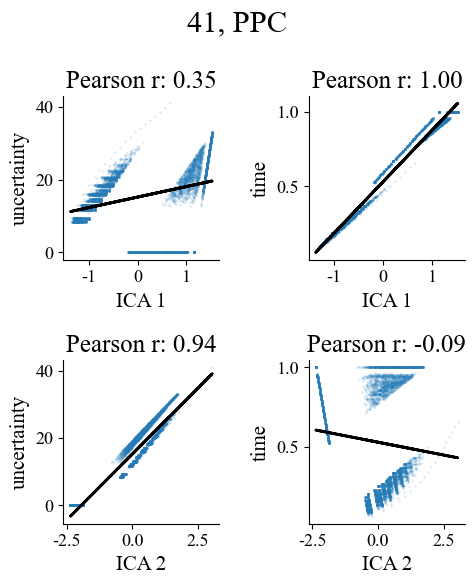

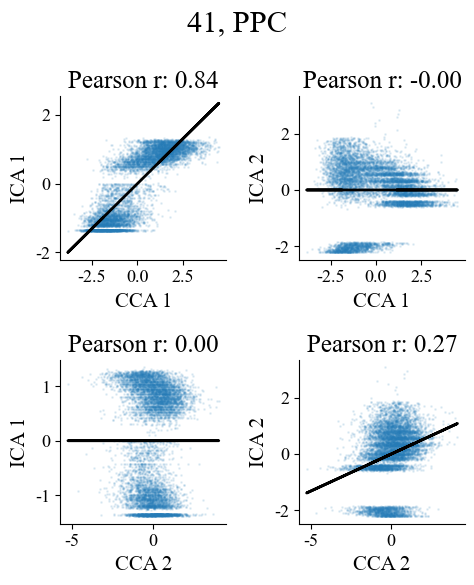

In [27]:
'''same as above, but use decouple data 
'''
trialstart=2 # need to be >1 to take diffs.
neural_data,beh_uncertainty,trial_time=np.concatenate([a[trialstart:] for a in sessdf.PPC.to_numpy()]), np.concatenate([a[trialstart:] for a in sessdf.relcov.to_numpy()])[:,0,0]**0.5, np.concatenate([a[trialstart:] for a in sessdf.time_ratio.to_numpy()]) 
trial_timename='time ratio'

# get mask (decouple time and uncertainty)
model = LinearRegression()
model.fit(beh_uncertainty.reshape(-1, 1),trial_time)
pred_time=model.predict(beh_uncertainty.reshape(-1, 1))
err=np.array(normalize_z(np.abs(pred_time-trial_time)))
mask=err>0.2
# only use the decouple data to fit
neural_data,beh_uncertainty, trial_time = neural_data[mask],beh_uncertainty[mask], trial_time[mask]
# get neural uncertainty
model = LinearRegression()
model.fit(neural_data,beh_uncertainty)
neural_uncertainty=model.predict(neural_data)


# neural_data,beh_uncertainty,trial_time=np.stack(thisdf.PPC.to_numpy()),np.stack(thisdf.uncertainty.to_numpy())[:,0,0]**0.5,thisdf.timeratio.to_numpy()
# # beh_uncertainty,trial_time=zip(*process_list([beh_uncertainty,trial_time]))
# neural_data,beh_uncertainty,trial_time=np.array(neural_data),np.array(beh_uncertainty),np.array(trial_time)
# # trial_time,_=process_one(trial_time)
# neural_dataname, beh_uncertaintyname, trial_timename='neural pred uncertainty', 'uncertainty','time ratio'

related_taskvar=np.stack([beh_uncertainty, trial_time]).T
ica = FastICA(n_components=2)
icaX=related_taskvar
icaS = ica.fit_transform(icaX) 


varname=['uncertainty', 'time']
fig, axs = plt.subplots(2,2, figsize=(5,6))
for i in range(2):
    for j in range(2):
        ax=axs[i,j]
        ax.scatter(icaS[:,i],related_taskvar[:,j], s=1, alpha=0.1)
        # best fit line
        slope, intercept = np.polyfit(icaS[:,i],related_taskvar[:,j], 1)
        best_fit_line = slope * icaS[:,i] + intercept
        ax.plot(icaS[:,i], best_fit_line, color='black')
        # quickallspine(ax)
        # ax.axis('equal')
        r,_=pearsonr(icaS[:,i],related_taskvar[:,j])
        # ax.set_title(f'x: cca {i+1} \ny: {varname[j]}\nPeason r: {r:.2f}')
        ax.set_title(f'Pearson r: {r:.2f}')
        ax.set_xlabel(f'ICA {i+1}')
        ax.set_ylabel(f'{varname[j]}')
plt.suptitle(f'{session}, PPC', fontsize=22)
plt.tight_layout()
plt.show()


trialstart=2 # need to be >1 to take diffs.
neural_data,beh_uncertainty,trial_time=np.concatenate([a[trialstart:] for a in sessdf.PPC.to_numpy()]), np.concatenate([a[trialstart:] for a in sessdf.relcov.to_numpy()])[:,0,0]**0.5, np.concatenate([a[trialstart:] for a in sessdf.time_ratio.to_numpy()]) 
trial_timename='time ratio'

# get mask (decouple time and uncertainty)
model = LinearRegression()
model.fit(beh_uncertainty.reshape(-1, 1),trial_time)
pred_time=model.predict(beh_uncertainty.reshape(-1, 1))
err=np.array(normalize_z(np.abs(pred_time-trial_time)))
mask=err>0.2
# only use the decouple data to fit
neural_data,beh_uncertainty, trial_time = neural_data[mask],beh_uncertainty[mask], trial_time[mask]
# get neural uncertainty
model = LinearRegression()
model.fit(neural_data,beh_uncertainty)
neural_uncertainty=model.predict(neural_data)

neural_dataname, beh_uncertaintyname, trial_timename='neural pred uncertainty', 'uncertainty','time ratio'

related_taskvar=np.stack([beh_uncertainty, trial_time]).T
cca = CCA(n_components=2)
cca_neural, cca_be=cca.fit_transform(neural_data,icaS )


varname=['ICA 1', 'ICA 2']
fig, axs = plt.subplots(2,2, figsize=(5,6))
for i in range(2):
    for j in range(2):
        ax=axs[i,j]
        ax.scatter(cca_neural[:,i],cca_be[:,j], s=1, alpha=0.1)
        # best fit line
        slope, intercept = np.polyfit(cca_neural[:,i],cca_be[:,j], 1)
        best_fit_line = slope * cca_neural[:,i] + intercept
        ax.plot(cca_neural[:,i], best_fit_line, color='black')
        # quickallspine(ax)
        # ax.axis('equal')
        r,_=pearsonr(cca_neural[:,i],cca_be[:,j])
        # ax.set_title(f'x: cca {i+1} \ny: {varname[j]}\nPeason r: {r:.2f}')
        ax.set_title(f'Pearson r: {r:.2f}')
        ax.set_xlabel(f'CCA {i+1}')
        ax.set_ylabel(f'{varname[j]}')
plt.suptitle(f'{session}, PPC', fontsize=22)
plt.tight_layout()
plt.show()

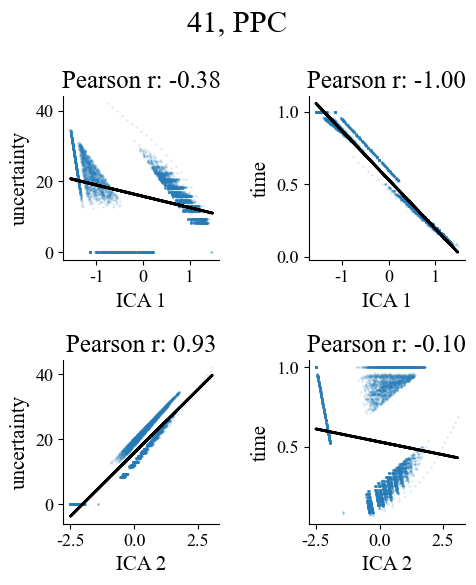

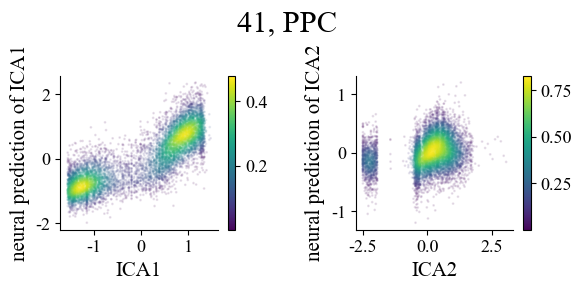

In [28]:
'''use ica to sperate time and uncertainty, and use neural to fit the isolated uncertainty component.
'''
trialstart=2 # need to be >1 to take diffs.
neural_data,beh_uncertainty,trial_time=np.concatenate([a[trialstart:] for a in sessdf.PPC.to_numpy()]), np.concatenate([a[trialstart:] for a in sessdf.relcov.to_numpy()])[:,0,0]**0.5, np.concatenate([a[trialstart:] for a in sessdf.time_ratio.to_numpy()]) 
trial_timename='time ratio'

# get mask (decouple time and uncertainty)
model = LinearRegression()
model.fit(beh_uncertainty.reshape(-1, 1),trial_time)
pred_time=model.predict(beh_uncertainty.reshape(-1, 1))
err=np.array(normalize_z(np.abs(pred_time-trial_time)))
mask=err>0.05
# only use the decouple data to fit
neural_data,beh_uncertainty, trial_time = neural_data[mask],beh_uncertainty[mask], trial_time[mask]


related_taskvar=np.stack([beh_uncertainty, trial_time]).T
ica = FastICA(n_components=2)
icaX=related_taskvar
icaS = ica.fit_transform(icaX) 

varname=['uncertainty', 'time']
fig, axs = plt.subplots(2,2, figsize=(5,6))
for i in range(2):
    for j in range(2):
        ax=axs[i,j]
        ax.scatter(icaS[:,i],related_taskvar[:,j], s=1, alpha=0.1)
        # best fit line
        slope, intercept = np.polyfit(icaS[:,i],related_taskvar[:,j], 1)
        best_fit_line = slope * icaS[:,i] + intercept
        ax.plot(icaS[:,i], best_fit_line, color='black')
        # quickallspine(ax)
        # ax.axis('equal')
        r,_=pearsonr(icaS[:,i],related_taskvar[:,j])
        # ax.set_title(f'x: cca {i+1} \ny: {varname[j]}\nPeason r: {r:.2f}')
        ax.set_title(f'Pearson r: {r:.2f}')
        ax.set_xlabel(f'ICA {i+1}')
        ax.set_ylabel(f'{varname[j]}')
plt.suptitle(f'{session}, PPC', fontsize=22)
plt.tight_layout()
plt.show()


fig, axs = plt.subplots(1,2, figsize=(6,3))
for j in range(2):
    ax=axs[j]
    ica_isolate=icaS[:,j]
    model=LinearRegression()
    model.fit(neural_data, ica_isolate)
    neural_uncertainty_component=model.predict(neural_data)
    scatter_density=compute_scatter_density(ica_isolate, neural_uncertainty_component)
    c=ax.scatter(ica_isolate, neural_uncertainty_component,c=scatter_density, s=1, alpha=0.1)
    cbar=plt.colorbar(c)
    solidcbar(cbar)
    ax.set_xlabel(f'ICA{j+1}')
    ax.set_ylabel(f'neural prediction of ICA{j+1}')
plt.suptitle(f'{session}, PPC', fontsize=22)
plt.tight_layout()
plt.show()

In [29]:
# # neural uncertainty heading vs observation. a inital check
# thisx, thisy=np.concatenate([a[:-1] for a in sessdf.relcov.to_numpy()])[:,0,0]**0.5, np.concatenate([a[:-1] for a in sessdf.mw.to_numpy()])
# thisy=np.abs(thisy)

# neural_data=np.concatenate([a[:-1] for a in sessdf.PPC.to_numpy()])
# model = LinearRegression()
# model.fit(neural_data, thisx)
# pred=model.predict(neural_data)

# fig,ax=plt.subplots(1,1)
# plt.scatter(thisx,thisy,s=1,alpha=0.3)
# plt.xlabel('behavior belief uncertainty, degree')
# plt.ylabel('observation, degree/dt')
# # plt.axis('equal')
# plt.show()

# fig,ax=plt.subplots(1,1)
# plt.scatter(pred,thisy,s=1,alpha=0.3)
# plt.xlabel('neural belief uncertainty, degree')
# plt.ylabel('observation, degree/dt')
# # plt.axis('equal')
# plt.show()

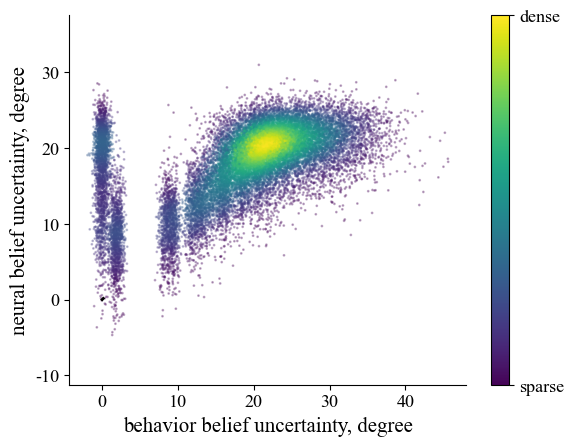

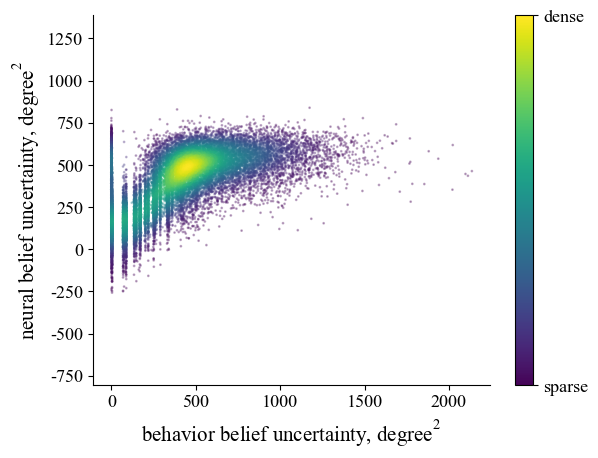

In [30]:
# neural uncertainty vs behavior uncertainty
# we have some level of neural encoding, in std not in variance?

# fit neural for std
thisx, thisy=np.concatenate([a[1:] for a in sessdf.relcov.to_numpy()])[:,0,0]**0.5, np.concatenate([a[1:] for a in sessdf.mw.to_numpy()]) # std
thisy=np.abs(thisy)

neural_data=np.concatenate([a[1:] for a in sessdf.PPC.to_numpy()])
model = LinearRegression()
model.fit(neural_data, thisx)
pred=model.predict(neural_data) # neural belief uncertainty
scatter_density=compute_scatter_density(thisx, pred)

fig,ax=plt.subplots(1,1)
c=plt.scatter(thisx+np.random.randn(*thisx.shape)*0.5,pred,c=scatter_density, s=1,alpha=0.3)
cbar=plt.colorbar(c)
cbar.set_ticks([min(scatter_density),max(scatter_density)],labels=['sparse','dense'])
solidcbar(cbar)
plt.plot([0,.15],[0,.15],'k')
plt.xlabel('behavior belief uncertainty, degree')
plt.ylabel('neural belief uncertainty, degree')
plt.axis('equal')
plt.show()

# fit neural for variance
thisx=np.concatenate([a[1:] for a in sessdf.relcov.to_numpy()])[:,0,0] # var
neural_data=np.concatenate([a[1:] for a in sessdf.PPC.to_numpy()])
model = LinearRegression()
model.fit(neural_data, thisx)
pred=model.predict(neural_data) # neural belief uncertainty
scatter_density=compute_scatter_density(thisx, pred)


fig,ax=plt.subplots(1,1)
c=plt.scatter(thisx+np.random.randn(*thisx.shape)*0.5,pred,c=scatter_density, s=1,alpha=0.3)
cbar=plt.colorbar(c)
cbar.set_ticks([min(scatter_density),max(scatter_density)],labels=['sparse','dense'])
solidcbar(cbar)
plt.xlabel(r'behavior belief uncertainty, degree$^2$')
plt.ylabel(r'neural belief uncertainty, degree$^2$')
plt.axis('equal')
plt.show()

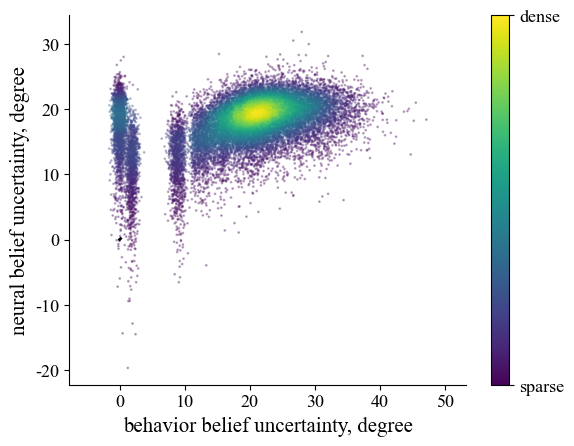

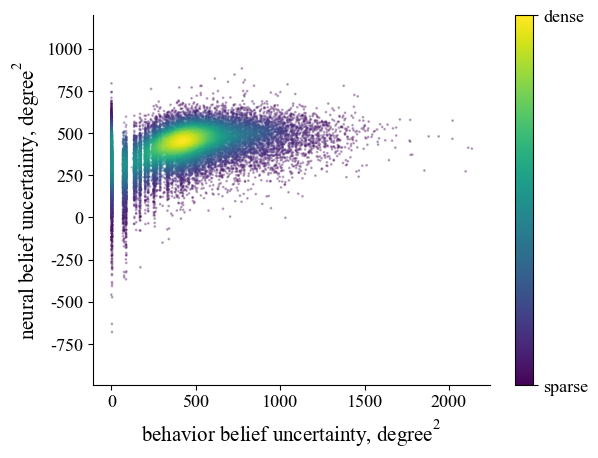

In [31]:
# neural uncertainty vs behavior uncertainty
# we have some level of neural encoding, in std not in variance?

# fit neural for std
thisx, thisy=np.concatenate([a[1:] for a in sessdf.relcov.to_numpy()])[:,0,0]**0.5, np.concatenate([a[1:] for a in sessdf.mw.to_numpy()]) # std
thisy=np.abs(thisy)

neural_data=np.concatenate([a[1:] for a in sessdf.PPC_var.to_numpy()])
model = LinearRegression()
model.fit(neural_data, thisx)
pred=model.predict(neural_data) # neural belief uncertainty
scatter_density=compute_scatter_density(thisx, pred)

fig,ax=plt.subplots(1,1)
c=plt.scatter(thisx+np.random.randn(*thisx.shape)*0.5,pred,c=scatter_density, s=1,alpha=0.3)
cbar=plt.colorbar(c)
cbar.set_ticks([min(scatter_density),max(scatter_density)],labels=['sparse','dense'])
solidcbar(cbar)
plt.plot([0,.15],[0,.15],'k')
plt.xlabel('behavior belief uncertainty, degree')
plt.ylabel('neural belief uncertainty, degree')
plt.axis('equal')
plt.show()

# fit neural for variance
thisx=np.concatenate([a[1:] for a in sessdf.relcov.to_numpy()])[:,0,0] # var
neural_data=np.concatenate([a[1:] for a in sessdf.PPC_var.to_numpy()])
model = LinearRegression()
model.fit(neural_data, thisx)
pred=model.predict(neural_data) # neural belief uncertainty
scatter_density=compute_scatter_density(thisx, pred)


fig,ax=plt.subplots(1,1)
c=plt.scatter(thisx+np.random.randn(*thisx.shape)*0.5,pred,c=scatter_density, s=1,alpha=0.3)
cbar=plt.colorbar(c)
cbar.set_ticks([min(scatter_density),max(scatter_density)],labels=['sparse','dense'])
solidcbar(cbar)
plt.xlabel(r'behavior belief uncertainty, degree$^2$')
plt.ylabel(r'neural belief uncertainty, degree$^2$')
plt.axis('equal')
plt.show()

In [ ]:

'''
neural belief uncertainty - behavior belief uncertainty residuel, vs uncertainty.
the idea is: when neural encoding is noisy, uncertainty is large. the noisyness might be related to the residuel. beacuse behavior belief uncerainty is fixed, neural uncerainty is not fixed? not really clear.
'''

# fit neural for std
thisx, thisy=np.concatenate([a[1:] for a in sessdf.relcov.to_numpy()])[:,0,0]**0.5, np.concatenate([a[1:] for a in sessdf.mw.to_numpy()]) # std
thisy=np.abs(thisy)

neural_data=np.concatenate([a[1:] for a in sessdf.PPC.to_numpy()])
model = LinearRegression()
model.fit(neural_data, thisx)
pred=model.predict(neural_data) # neural belief uncertainty
scatter_density=compute_scatter_density(thisx+np.random.randn(*thisx.shape)*0.5,(thisx-pred))

fig,ax=plt.subplots(1,1)
c=plt.scatter(thisx+np.random.randn(*thisx.shape)*0.5,(thisx-pred),c=scatter_density, s=1,alpha=0.3)
cbar=plt.colorbar(c)
cbar.set_ticks([min(scatter_density),max(scatter_density)],labels=['sparse','dense'])
solidcbar(cbar)
mask=thisx>0.1
slope=plot_best_fit(thisx[mask], (thisx-pred)[mask], ax=plt.gca())
plt.title(f'slope = {slope:.2f}')
plt.xlabel('behavior belief uncertainty, degree')
plt.ylabel('behavior-neural belief uncertainty (residual), degree')
plt.axis('equal')
plt.show()

# fit neural for variance
thisx=np.concatenate([a[1:] for a in sessdf.relcov.to_numpy()])[:,0,0] # var
neural_data=np.concatenate([a[1:] for a in sessdf.PPC.to_numpy()])
model = LinearRegression()
model.fit(neural_data, thisx)
pred=model.predict(neural_data) # neural belief uncertainty
scatter_density=compute_scatter_density(thisx+np.random.randn(*thisx.shape)*0.25,(thisx-pred))

fig,ax=plt.subplots(1,1)
c=plt.scatter(thisx+np.random.randn(*thisx.shape)*0.25,(thisx-pred),c=scatter_density, s=1,alpha=0.3)
cbar=plt.colorbar(c)
cbar.set_ticks([min(scatter_density),max(scatter_density)],labels=['sparse','dense'])
solidcbar(cbar)
mask=thisx>0.01
slope=plot_best_fit(thisx[mask], (thisx-pred)[mask], ax=plt.gca())
plt.title(f'slope = {slope:.2f}')
plt.xlabel(r'behavior belief uncertainty, degree$^2$')
plt.ylabel(r'behavior-neural belief uncertainty (residual), degree$^2$')
plt.axis('equal')
plt.show()

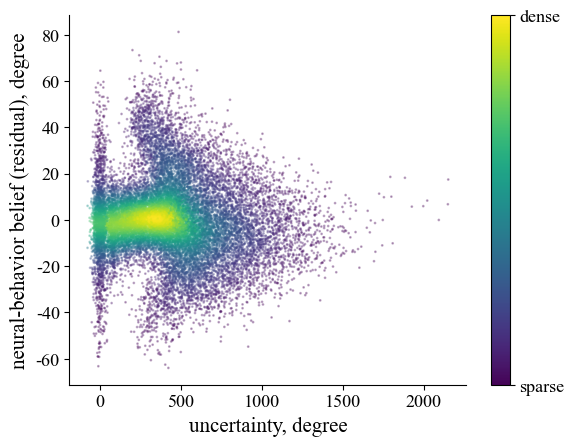

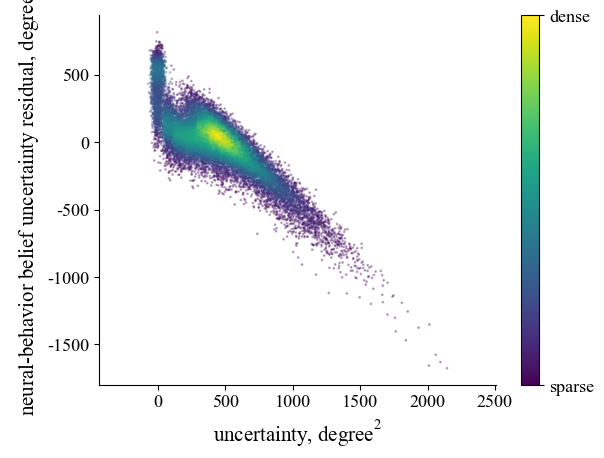

In [33]:

'''
neural belief - behavior belief residuel, vs uncertainty.
the idea is: when neural encoding is noisy, uncertainty is large. the noisyness might be related to the residuel. here the residual is a measurement of neural variance
'''
trialstart=2
uncertainty=np.concatenate([a[trialstart:] for a in sessdf.relcov.to_numpy()])[:,0,0] # var
thisx=np.concatenate([a[trialstart:] for a in sessdf.belief_heading]) # behavior blief heading
neural_data=np.concatenate([a[trialstart:] for a in sessdf.PPC.to_numpy()])
model = LinearRegression()
model.fit(neural_data, thisx)
neural_uncertainty=model.predict(neural_data) # neural belief heading
residual=neural_uncertainty-thisx

fig,ax=plt.subplots(1,1)
scatter_density=compute_scatter_density(uncertainty,(residual))
c=plt.scatter(uncertainty+np.random.randn(*uncertainty.shape)*22,(residual),c=scatter_density, s=1,alpha=0.3)
cbar=plt.colorbar(c)
cbar.set_ticks([min(scatter_density),max(scatter_density)],labels=['sparse','dense'])
solidcbar(cbar)
# mask=thisx>0.1
# slope=plot_best_fit(thisx[mask], (thisx-neural_uncertainty)[mask], ax=plt.gca())
# plt.title(f'slope = {slope:.2f}')
plt.xlabel('uncertainty, degree')
plt.ylabel('neural-behavior belief (residual), degree')
# plt.axis('equal')
plt.show()

# fit neural for variance
thisx=np.concatenate([a[trialstart:] for a in sessdf.relcov.to_numpy()])[:,0,0] # var
neural_data=np.concatenate([a[trialstart:] for a in sessdf.PPC.to_numpy()])
model = LinearRegression()
model.fit(neural_data, thisx)
neural_uncertainty=model.predict(neural_data) # neural belief uncertainty
residual=neural_uncertainty-thisx

fig,ax=plt.subplots(1,1)
# plt.scatter(uncertainty,np.abs(residual),s=1,alpha=0.3)
scatter_density=compute_scatter_density(uncertainty,(residual))
c=plt.scatter(uncertainty+np.random.randn(*uncertainty.shape)*22,(residual),c=scatter_density, s=1,alpha=0.3)
cbar=plt.colorbar(c)
cbar.set_ticks([min(scatter_density),max(scatter_density)],labels=['sparse','dense'])
solidcbar(cbar)
mask=uncertainty>0.0151
# slope=plot_best_fit(uncertainty[mask], np.abs(residual)[mask], ax=plt.gca())
# plt.title(f'slope = {slope:.2f}')
plt.xlabel(r'uncertainty, degree$^2$')
plt.ylabel(r'neural-behavior belief uncertainty residual, degree$^2$')
plt.axis('equal')
plt.show()

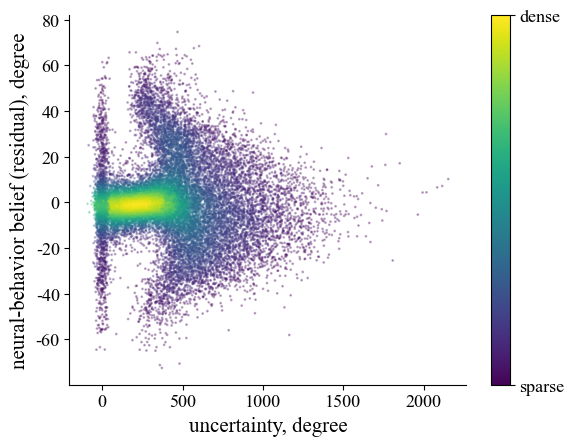

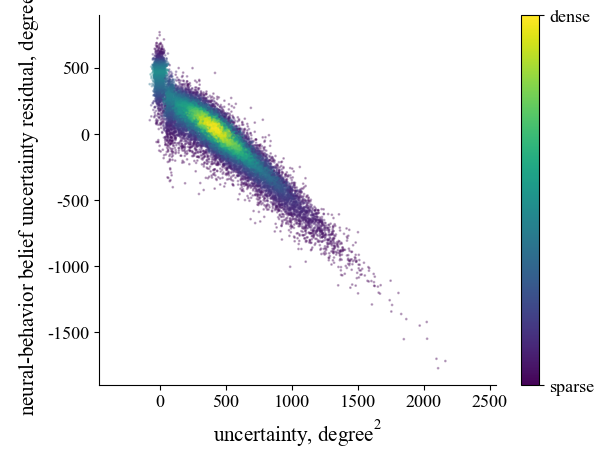

In [34]:

'''
neural belief - behavior belief residuel, vs uncertainty.
the idea is: when neural encoding is noisy, uncertainty is large. the noisyness might be related to the residuel. here the residual is a measurement of neural variance
'''
trialstart=2
uncertainty=np.concatenate([a[trialstart:] for a in sessdf.relcov.to_numpy()])[:,0,0] # var
thisx=np.concatenate([a[trialstart:] for a in sessdf.belief_heading]) # behavior blief heading
neural_data=np.concatenate([a[trialstart:] for a in sessdf.PPC_var.to_numpy()])
model = LinearRegression()
model.fit(neural_data, thisx)
neural_uncertainty=model.predict(neural_data) # neural belief heading
residual=neural_uncertainty-thisx

fig,ax=plt.subplots(1,1)
scatter_density=compute_scatter_density(uncertainty,(residual))
c=plt.scatter(uncertainty+np.random.randn(*uncertainty.shape)*22,(residual),c=scatter_density, s=1,alpha=0.3)
cbar=plt.colorbar(c)
cbar.set_ticks([min(scatter_density),max(scatter_density)],labels=['sparse','dense'])
solidcbar(cbar)
# mask=thisx>0.1
# slope=plot_best_fit(thisx[mask], (thisx-neural_uncertainty)[mask], ax=plt.gca())
# plt.title(f'slope = {slope:.2f}')
plt.xlabel('uncertainty, degree')
plt.ylabel('neural-behavior belief (residual), degree')
# plt.axis('equal')
plt.show()

# fit neural for variance
thisx=np.concatenate([a[trialstart:] for a in sessdf.relcov.to_numpy()])[:,0,0] # var
neural_data=np.concatenate([a[trialstart:] for a in sessdf.PPC_var.to_numpy()])
model = LinearRegression()
model.fit(neural_data, thisx)
neural_uncertainty=model.predict(neural_data) # neural belief uncertainty
residual=neural_uncertainty-thisx

fig,ax=plt.subplots(1,1)
# plt.scatter(uncertainty,np.abs(residual),s=1,alpha=0.3)
scatter_density=compute_scatter_density(uncertainty,(residual))
c=plt.scatter(uncertainty+np.random.randn(*uncertainty.shape)*22,(residual),c=scatter_density, s=1,alpha=0.3)
cbar=plt.colorbar(c)
cbar.set_ticks([min(scatter_density),max(scatter_density)],labels=['sparse','dense'])
solidcbar(cbar)
mask=uncertainty>0.0151
# slope=plot_best_fit(uncertainty[mask], np.abs(residual)[mask], ax=plt.gca())
# plt.title(f'slope = {slope:.2f}')
plt.xlabel(r'uncertainty, degree$^2$')
plt.ylabel(r'neural-behavior belief uncertainty residual, degree$^2$')
plt.axis('equal')
plt.show()

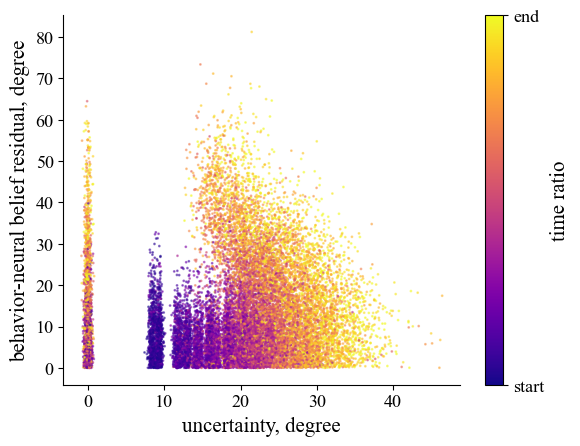

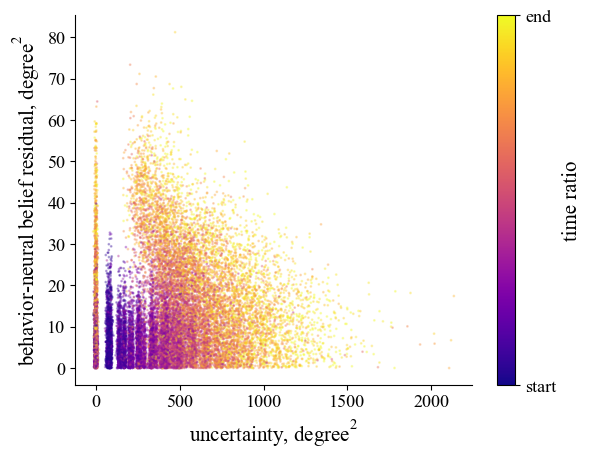

In [35]:

'''
neural belief - behavior belief residuel, vs uncertainty.
the idea is: when neural encoding is noisy, uncertainty is large. the noisyness might be related to the residuel. here the residual is a measurement of neural variance
'''
trialstart=2
uncertainty=np.concatenate([a[trialstart:] for a in sessdf.relcov.to_numpy()])[:,0,0]**0.5 # std
thisx=np.concatenate([a[trialstart:] for a in sessdf.belief_heading]) # behavior belief heading
thisc=np.concatenate([a[trialstart:] for a in sessdf.time_ratio])
neural_data=np.concatenate([a[trialstart:] for a in sessdf.PPC.to_numpy()])
model = LinearRegression()
model.fit(neural_data, thisx)
pred=model.predict(neural_data) # neural belief heading
residual=pred-thisx

mask=(np.concatenate([a[trialstart:] for a in sessdf.timer])>7)&(np.concatenate([a[trialstart:] for a in sessdf.triallen_t])>2)
mask=(np.concatenate([a[trialstart:] for a in sessdf.triallen_t])>2)

uncertainty, residual, thisc=uncertainty[mask], residual[mask], thisc[mask]
fig,ax=plt.subplots(1,1)
c=plt.scatter(uncertainty+np.random.randn(*uncertainty.shape)*0.25,np.abs(residual),c=thisc, cmap='plasma',s=1,alpha=0.5)
cbar=plt.colorbar(c, label='time ratio')
cbar.set_ticks([min(thisc),max(thisc)],labels=['start','end'])
solidcbar(cbar)
# mask=thisx>0.1
# slope=plot_best_fit(uncertainty,np.abs(residual) , ax=plt.gca())
# plt.title(f'slope = {slope:.2f}')
plt.xlabel('uncertainty, degree')
plt.ylabel('behavior-neural belief residual, degree')
# plt.axis('equal')
plt.show()

# variance
uncertainty=np.concatenate([a[trialstart:] for a in sessdf.relcov.to_numpy()])[:,0,0] # var
uncertainty=uncertainty[mask]

fig,ax=plt.subplots(1,1)
c=plt.scatter(uncertainty+np.random.randn(*uncertainty.shape)*5,np.abs(residual),c=thisc, cmap='plasma',s=1,alpha=0.3)
cbar=plt.colorbar(c, label='time ratio')
cbar.set_ticks([min(thisc),max(thisc)],labels=['start','end'])
solidcbar(cbar)
# mask=uncertainty>0.0151
# slope=plot_best_fit(uncertainty[mask], np.abs(residual)[mask], ax=plt.gca())
# plt.title(f'slope = {slope:.2f}')
plt.xlabel(r'uncertainty, degree$^2$')
plt.ylabel(r'behavior-neural belief residual, degree$^2$')
# plt.axis('equal')
plt.show()

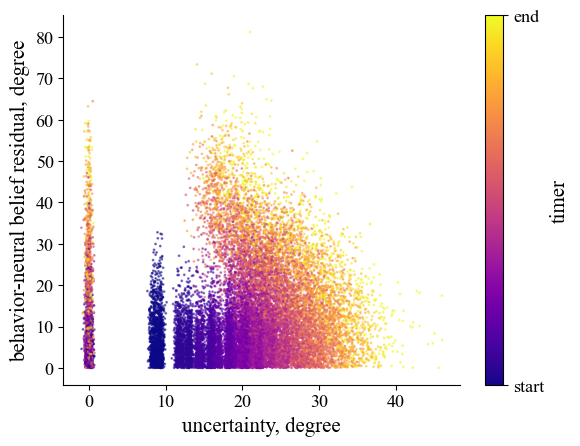

In [36]:

'''
neural belief - behavior belief residuel, vs uncertainty.
the idea is: when neural encoding is noisy, uncertainty is large. the noisyness might be related to the residuel. here the residual is a measurement of neural variance
'''

trialstart=2
uncertainty=np.concatenate([a[trialstart:] for a in sessdf.relcov.to_numpy()])[:,0,0]**0.5 # std
thisx=np.concatenate([a[trialstart:] for a in sessdf.belief_heading]) # behavior belief heading
thisc=np.concatenate([a[trialstart:] for a in sessdf.timer])
neural_data=np.concatenate([a[trialstart:] for a in sessdf.PPC.to_numpy()])
model = LinearRegression()
model.fit(neural_data, thisx)
pred=model.predict(neural_data) # neural belief heading
residual=pred-thisx

mask=(np.concatenate([a[trialstart:] for a in sessdf.timer])>7)&(np.concatenate([a[trialstart:] for a in sessdf.triallen_t])>2)
mask=(np.concatenate([a[trialstart:] for a in sessdf.triallen_t])>2)

uncertainty, residual, thisc=uncertainty[mask], residual[mask], thisc[mask]
fig,ax=plt.subplots(1,1)
vmax=20
c=plt.scatter(uncertainty+np.random.randn(*uncertainty.shape)*0.25,np.abs(residual),c=thisc,vmax=vmax, cmap='plasma',s=1,alpha=0.5)
cbar=plt.colorbar(c, label='timer')
cbar.set_ticks([min(thisc),vmax],labels=['start','end'])
solidcbar(cbar)
# mask=thisx>0.1
# slope=plot_best_fit(uncertainty,np.abs(residual) , ax=plt.gca())
# plt.title(f'slope = {slope:.2f}')
plt.xlabel('uncertainty, degree')
plt.ylabel('behavior-neural belief residual, degree')
# plt.axis('equal')
plt.show()

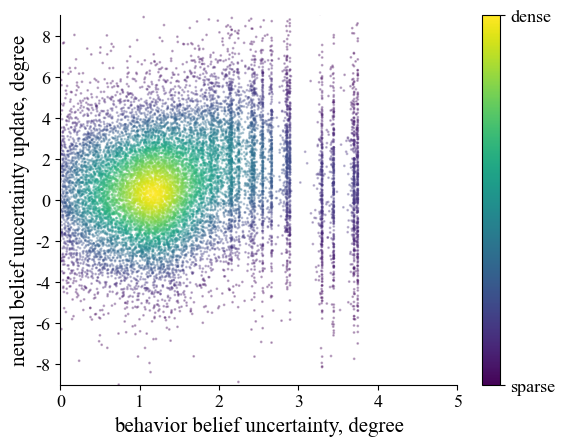

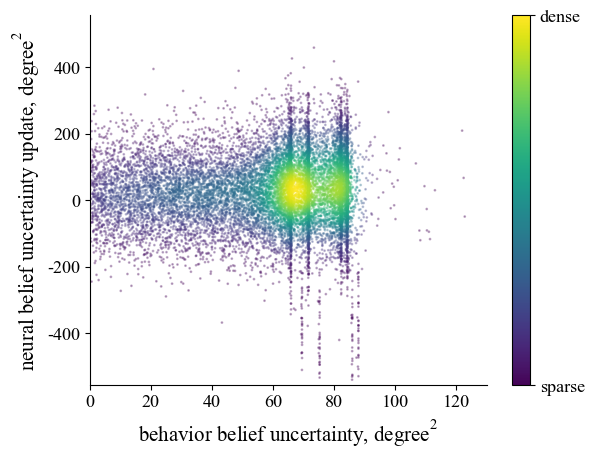

In [37]:

'''
neural belief update, vs uncertainty. no corr. bad result
'''
trialstart=2
# fit neural for std
thisx=np.concatenate([a[trialstart:] for a in sessdf.relcov.to_numpy()])[:,0,0]**0.5
neural_data=np.concatenate([a[trialstart:] for a in sessdf.PPC.to_numpy()])
model = LinearRegression()
model.fit(neural_data, thisx)
pred=model.predict(neural_data) # neural belief uncertainty

fig,ax=plt.subplots(1,1)
mask=np.diff(thisx)>0
scatter_density=compute_scatter_density(np.diff(thisx)[mask], np.diff(pred)[mask])
c=plt.scatter(np.diff(thisx)[mask], np.diff(pred)[mask],c=scatter_density, s=1,alpha=0.3)
cbar=plt.colorbar(c)
cbar.set_ticks([min(scatter_density),max(scatter_density)],labels=['sparse','dense'])
solidcbar(cbar)
plt.xlabel('behavior belief uncertainty, degree')
plt.ylabel('neural belief uncertainty update, degree')
# plt.axis('equal')
plt.xlim(0,5)
plt.ylim(-9,9)
plt.show()



# fit neural for variance
thisx=np.concatenate([a[trialstart:] for a in sessdf.relcov.to_numpy()])[:,0,0]
neural_data=np.concatenate([a[trialstart:] for a in sessdf.PPC.to_numpy()])
model = LinearRegression()
model.fit(neural_data, thisx)
pred=model.predict(neural_data) # neural belief uncertainty

fig,ax=plt.subplots(1,1)
mask=np.diff(thisx)>0
scatter_density=compute_scatter_density(np.diff(thisx)[mask], np.diff(pred)[mask])
c=plt.scatter(np.diff(thisx)[mask], np.diff(pred)[mask],c=scatter_density, s=1,alpha=0.3)
cbar=plt.colorbar(c)
cbar.set_ticks([min(scatter_density),max(scatter_density)],labels=['sparse','dense'])
solidcbar(cbar)
plt.xlabel(r'behavior belief uncertainty, degree$^2$')
plt.ylabel(r'neural belief uncertainty update, degree$^2$')
plt.xlim(0,130)
plt.ylim(-555,555)
plt.show()

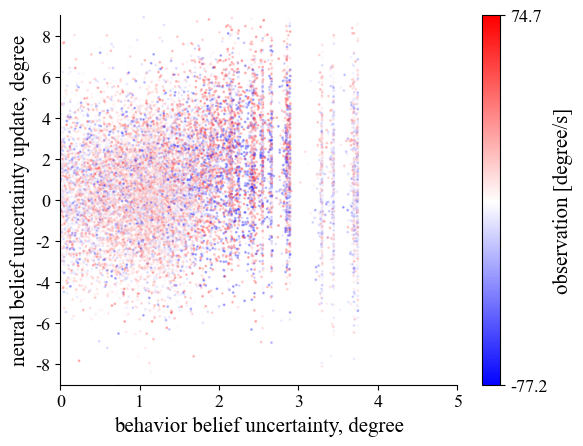

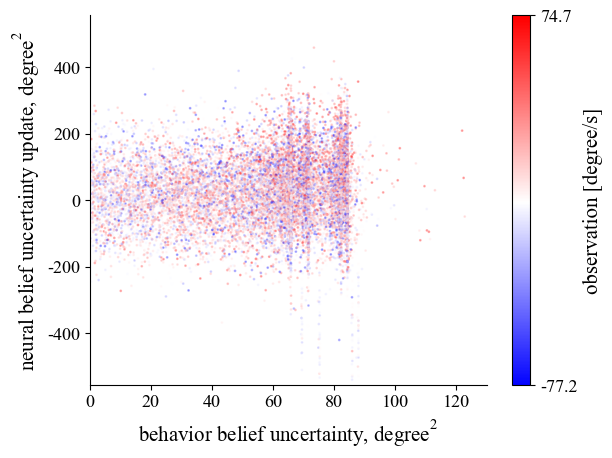

In [38]:

'''
neural belief update, vs uncertainty. color by obs (velocity)
'''
trialstart=2
# fit neural for std
thisx=np.concatenate([a[trialstart:] for a in sessdf.relcov.to_numpy()])[:,0,0]**0.5
neural_data=np.concatenate([a[trialstart:] for a in sessdf.PPC.to_numpy()])
thisc=np.concatenate([a[trialstart:] for a in sessdf.mw.to_numpy()])
model = LinearRegression()
model.fit(neural_data, thisx)
pred=model.predict(neural_data) # neural belief uncertainty

fig,ax=plt.subplots(1,1)
mask=np.diff(thisx)>0
c=plt.scatter(np.diff(thisx)[mask], np.diff(pred)[mask],c=thisc[1:][mask],cmap='bwr', s=1,alpha=0.3)
cbar=plt.colorbar(c, label='observation [degree/s]')
cbar.set_ticks([min(thisc[1:]),max(thisc[1:])])
solidcbar(cbar)
plt.xlabel('behavior belief uncertainty, degree')
plt.ylabel('neural belief uncertainty update, degree')
# plt.axis('equal')
plt.xlim(0,5)
plt.ylim(-9,9)
plt.show()



# fit neural for variance
thisx=np.concatenate([a[trialstart:] for a in sessdf.relcov.to_numpy()])[:,0,0]
neural_data=np.concatenate([a[trialstart:] for a in sessdf.PPC.to_numpy()])
model = LinearRegression()
model.fit(neural_data, thisx)
pred=model.predict(neural_data) # neural belief uncertainty

fig,ax=plt.subplots(1,1)
mask=np.diff(thisx)>0
c=plt.scatter(np.diff(thisx)[mask], np.diff(pred)[mask],c=thisc[1:][mask],cmap='bwr', s=1,alpha=0.3)
cbar=plt.colorbar(c, label='observation [degree/s]')
cbar.set_ticks([min(thisc[1:]),max(thisc[1:])])
solidcbar(cbar)
plt.xlabel(r'behavior belief uncertainty, degree$^2$')
plt.ylabel(r'neural belief uncertainty update, degree$^2$')
plt.xlim(0,130)
plt.ylim(-555,555)
plt.show()